In [6]:
import jax
jax.config.update("jax_enable_x64", True)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
print(jax.local_devices())

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

[cuda(id=0)]


In [7]:
from jax import jit, grad, vmap, hessian, value_and_grad
import optax

In [8]:
# Define the neural network
def init_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weights = random.normal(key, (m, n)) * jnp.sqrt(2 / m)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

def predict(params, x):
    activations = x
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [9]:
def count_parameters(params):
    total_params = 0
    for weights, biases in params:
        total_params += weights.size
        total_params += biases.size
    return total_params

In [10]:
def compute_1d_error(pred, u, x, y):
    norm_u = jnp.sqrt(integrate.trapezoid(u**2, x))
    norm_diff = jnp.sqrt(integrate.trapezoid((pred - u)**2, x))
    return norm_diff, norm_diff/norm_u

In [11]:
from importlib import reload
import utils_DST

utils_DST = reload(utils_DST)
from utils_DST import discrete_sine_transform, compute_sine_coefficients

# Using the DST for solving an elliptic PDE

We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

In our case we will have the domain be $[0,1]$ and so $L = 1.0$. Therefore

\begin{aligned}
\xi &=   \sqrt{2} \sum_{i}^\infty \xi_i \sin\Big(i\pi x\Big) \\
u &=  \sqrt{2}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{i^2\pi^2}{L^2} + 1\Big)}\sin\Big(i\pi x\Big)
\end{aligned}

Our solution will be found using a NN.


In [12]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [13]:
from importlib import reload
import utils_DST

utils_DST = reload(utils_DST)
from utils_DST import discrete_sine_transform

In [14]:
key = random.PRNGKey(635)
nu = 0.01


n_coef = 2**14
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print(n_coef)

frequencies = jnp.arange(0, n_coef) + 1
coef_f = jnp.hstack([random.normal(key, shape= (n_coef,))])
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = discrete_sine_transform(coef_f)
u_values = discrete_sine_transform(coef_u)

16384


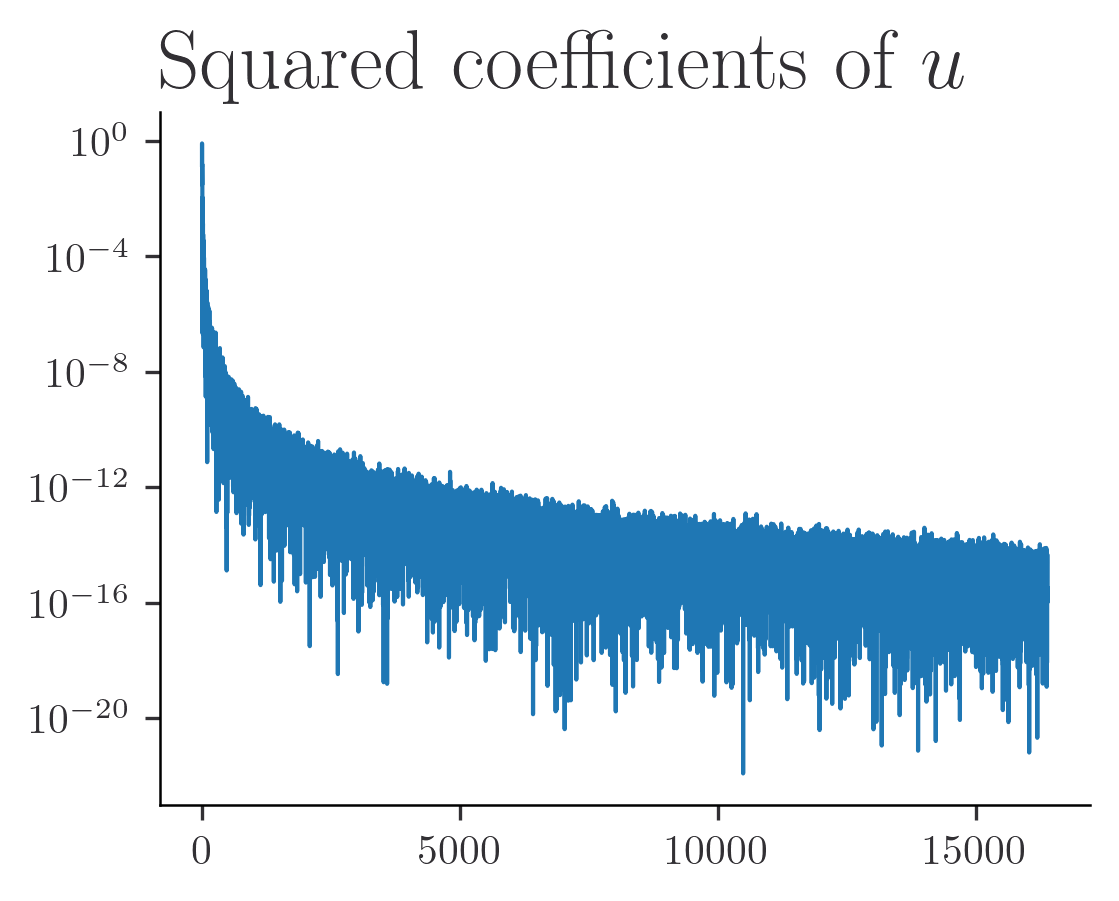

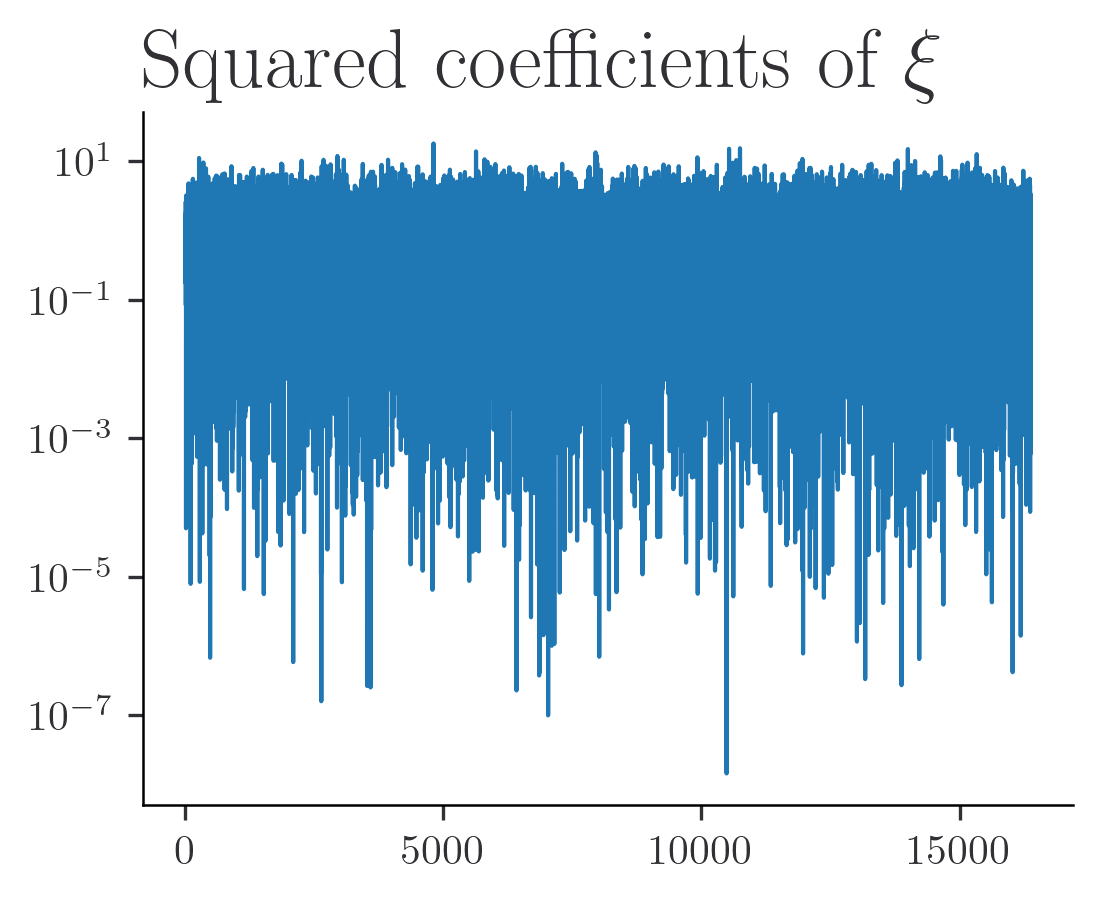

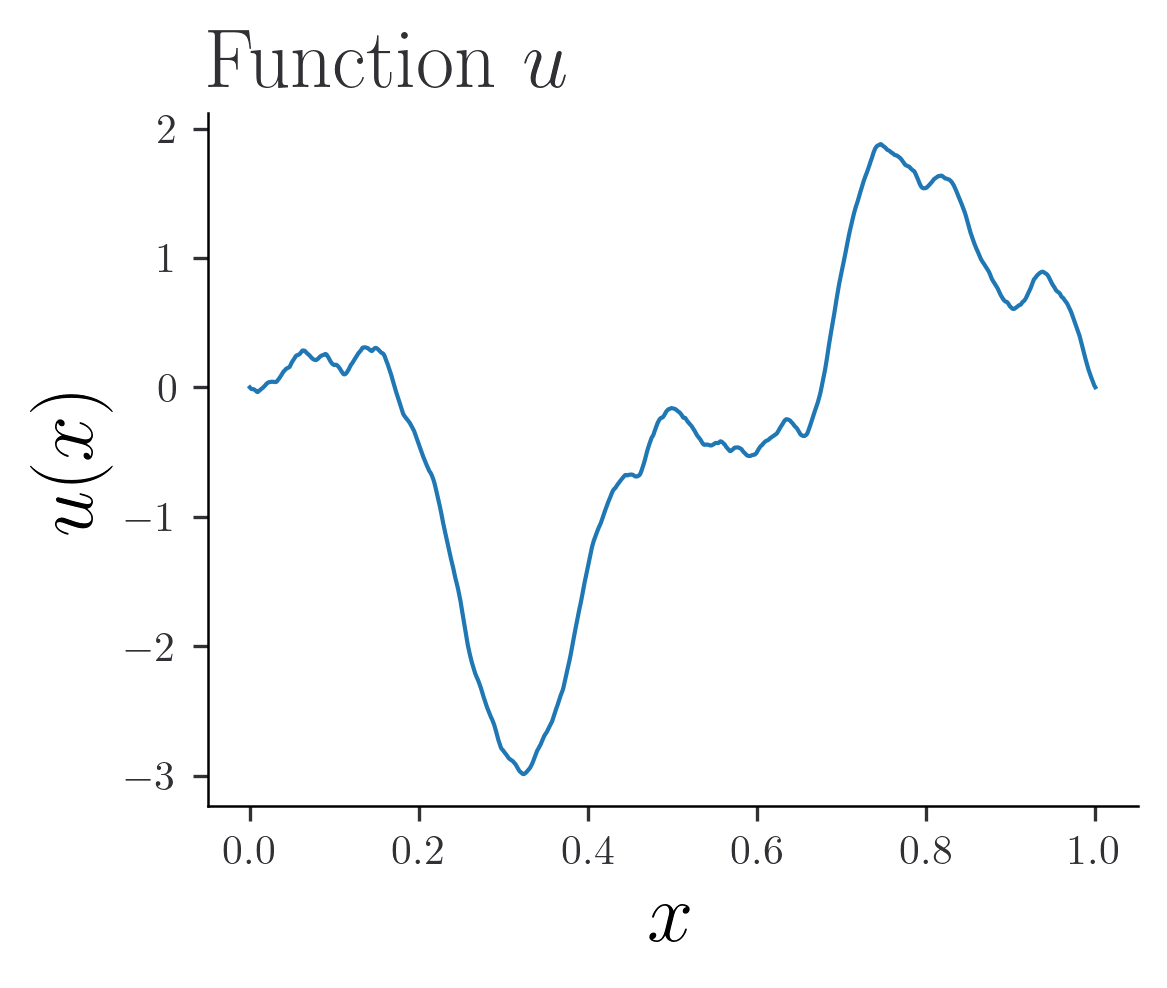

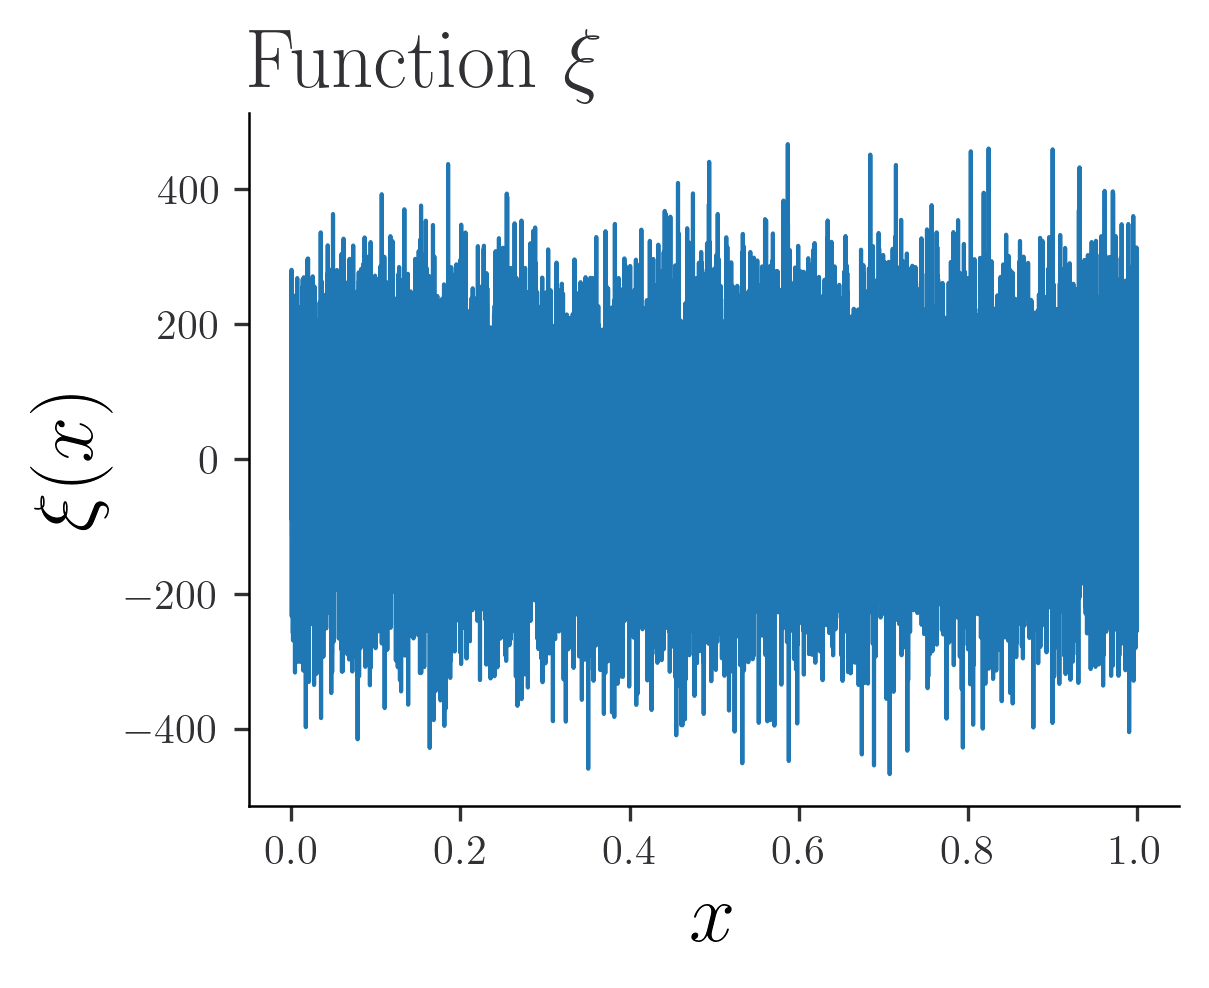

: 

In [16]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u$')


plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

# PINN 4096 measurements $L^2$

In [81]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [82]:
layer_sizes = [1, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 1153 parameters in the neural network.


In [83]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [84]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
1.2834959610802894 [(Array([[-6.75586185e-02, -6.98330962e-04,  1.30448892e-02,
        -1.76949760e-04, -3.58124946e-02, -1.38316625e-02,
        -2.55166238e-02,  2.34126802e-01,  4.33071423e-02,
        -1.51196850e-02, -1.09920438e-01,  2.95652056e-02,
        -1.75641995e-04, -2.59586935e-01, -1.17292707e-01,
        -2.10646967e-02, -2.87191406e-04,  1.73835519e-02,
        -9.70288358e-02, -5.72385228e-02,  4.85047669e-02,
         2.18344561e-02, -1.98503995e-01, -5.09899692e-03,
         1.77432520e-01, -1.97303041e-03,  7.18171277e-03,
         1.88725730e-01,  6.25826493e-04,  8.64494990e-02,
         7.67087337e-02, -1.70369381e-02]], dtype=float64), Array([-6.75455074e-02, -7.03009032e-04,  1.30467511e-02, -1.80345191e-04,
       -3.58179517e-02, -1.38363398e-02, -2.55000847e-02,  2.34113569e-01,
        4.32970171e-02, -1.51268076e-02, -1.09920616e-01,  2.95794154e-02,
       -1.77784378e-04, -2.59576405e-01, -1.17276683e-01, -2.10594094e-02,
       

In [85]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [86]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [87]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 1.2834960
Step 0, Training Loss: 1.2834960, Learning Rate: 0.001000
Epoch 10000, Loss: 0.9748585
Step 10000, Training Loss: 0.9748585, Learning Rate: 0.000900
Epoch 20000, Loss: 0.9660549
Step 20000, Training Loss: 0.9660549, Learning Rate: 0.000810
Epoch 30000, Loss: 0.9645601
Step 30000, Training Loss: 0.9645601, Learning Rate: 0.000729
Epoch 40000, Loss: 0.9613743
Step 40000, Training Loss: 0.9613743, Learning Rate: 0.000656
Epoch 50000, Loss: 0.9597968
Step 50000, Training Loss: 0.9597968, Learning Rate: 0.000590
Epoch 60000, Loss: 0.9588262
Step 60000, Training Loss: 0.9588262, Learning Rate: 0.000531
Epoch 70000, Loss: 0.9583673
Step 70000, Training Loss: 0.9583673, Learning Rate: 0.000478
Epoch 80000, Loss: 0.9558730
Step 80000, Training Loss: 0.9558730, Learning Rate: 0.000430
Epoch 90000, Loss: 0.9556716
Step 90000, Training Loss: 0.9556716, Learning Rate: 0.000387


In [88]:
pred = neural_network(params, domain_finest)

In [89]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

0.1117128996508573 0.08976654874324214


In [34]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(0.1117129, dtype=float64), Array(0.08976655, dtype=float64))

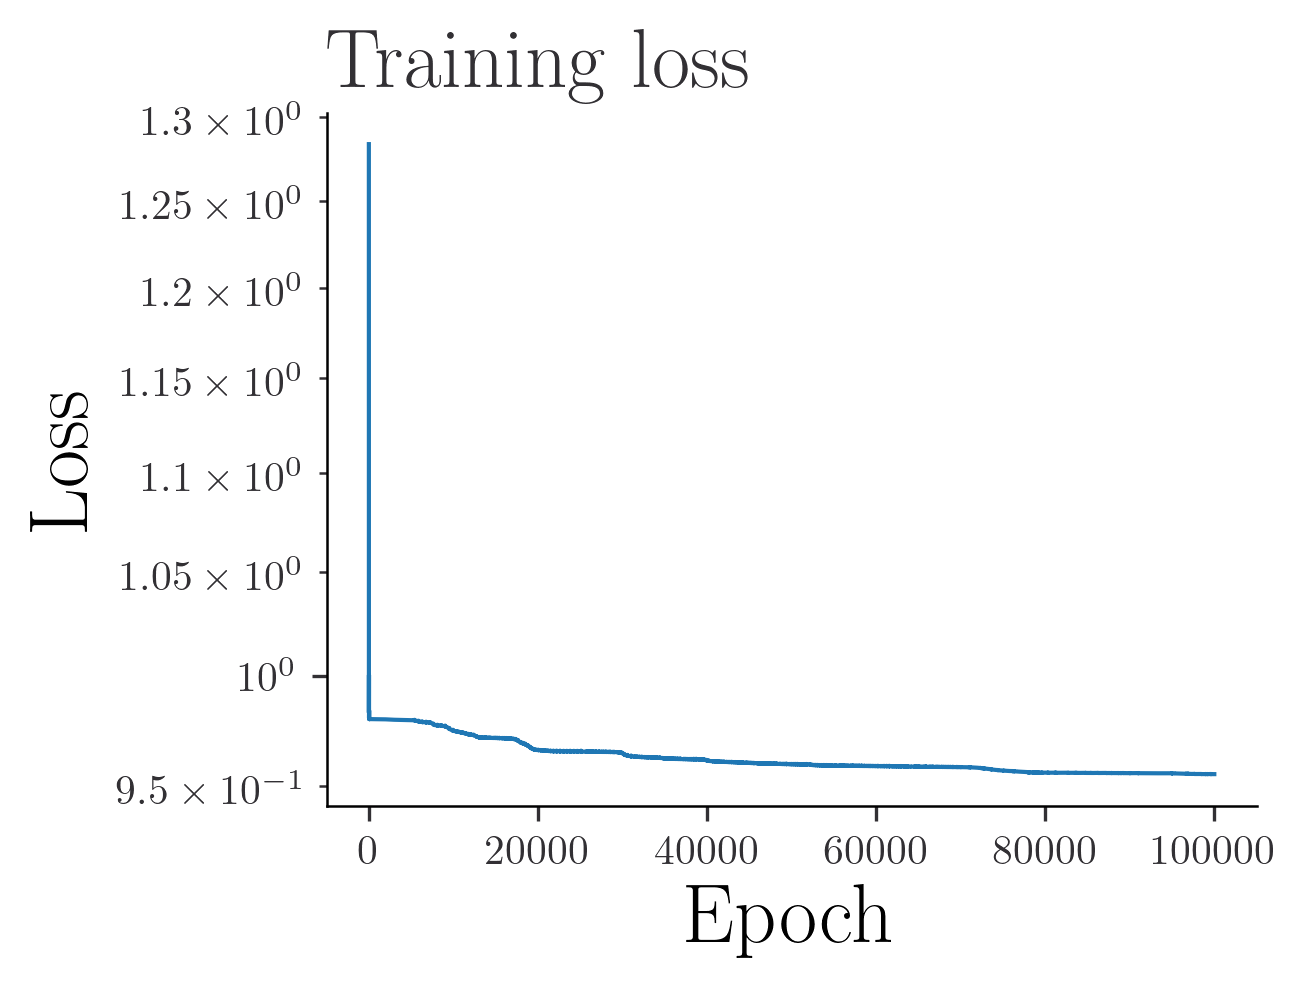

In [35]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

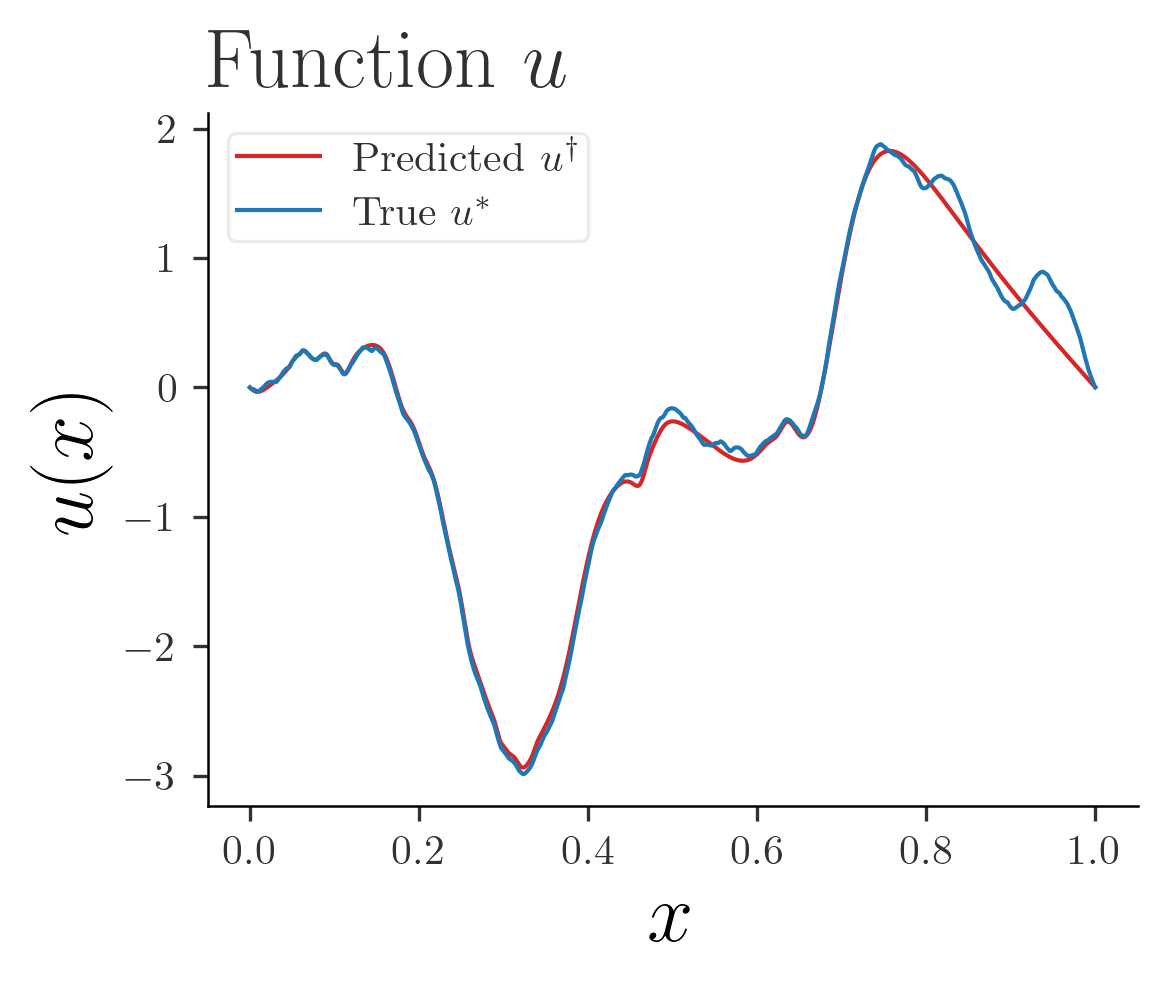

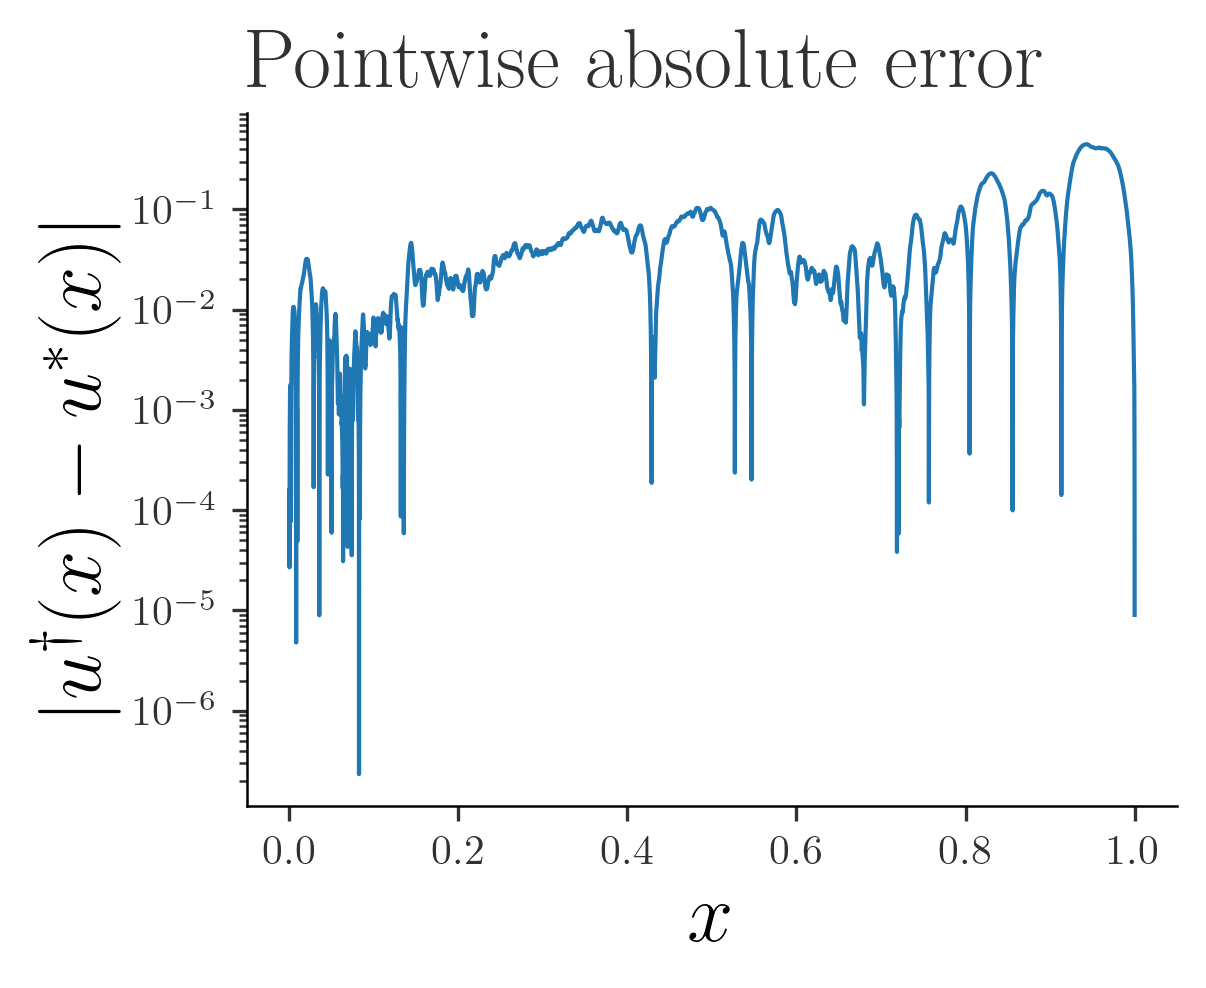

In [36]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


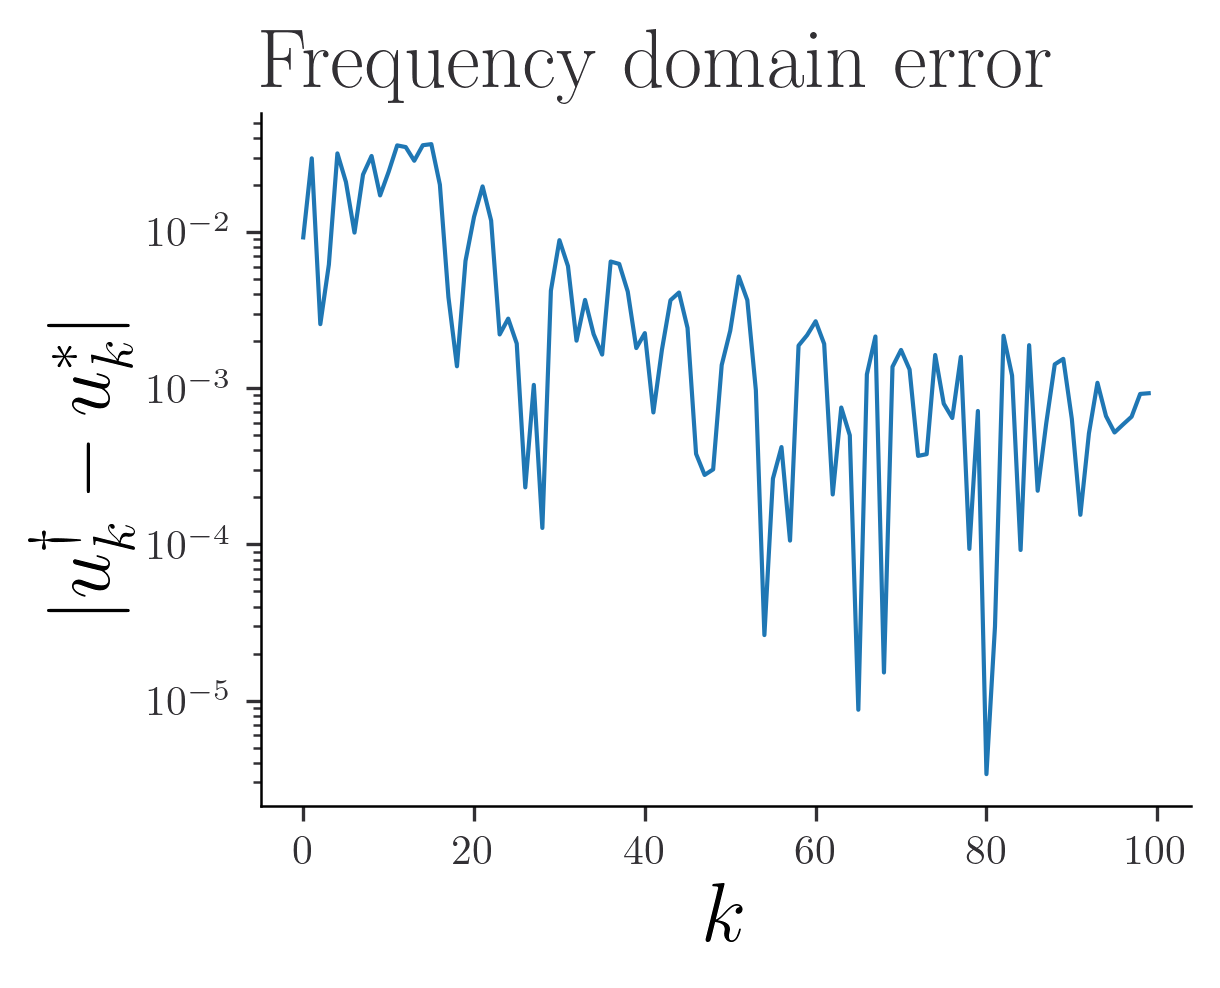

In [37]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

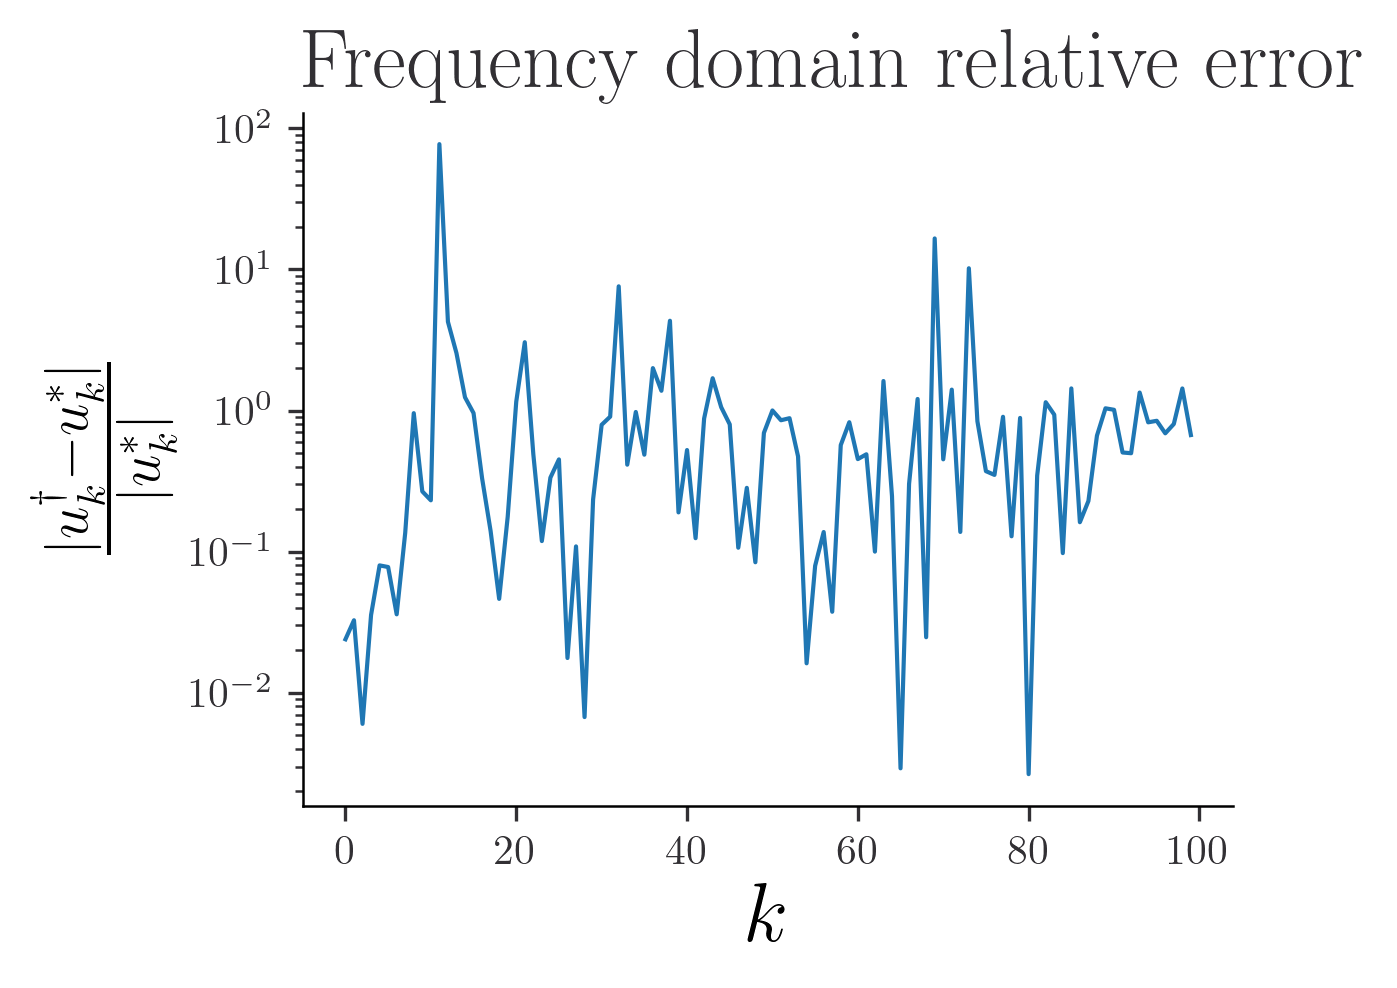

In [38]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements $H^{-1/2}$

In [24]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [25]:
t = 1/2
decay = jnp.arange(1, n_meas+1)**(-t/2)
decay

Array([1.        , 0.84089642, 0.75983569, ..., 0.12501526, 0.12500763,
       0.125     ], dtype=float64, weak_type=True)

In [29]:
layer_sizes = [1, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)*decay

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 1153 parameters in the neural network.


In [30]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [31]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
0.33291638012678804 [(Array([[-6.75518730e-02, -7.01454100e-04,  1.30424246e-02,
        -1.76280856e-04, -3.58101017e-02, -1.38307454e-02,
        -2.55147434e-02,  2.34106538e-01,  4.33039158e-02,
        -1.51190573e-02, -1.09908393e-01,  2.95611869e-02,
        -1.76180671e-04, -2.59562998e-01, -1.17281691e-01,
        -2.10634263e-02, -2.85722148e-04,  1.73884314e-02,
        -9.70189758e-02, -5.72319391e-02,  4.85017593e-02,
         2.18312682e-02, -1.98485711e-01, -5.09919585e-03,
         1.77416094e-01, -1.97333921e-03,  7.18255535e-03,
         1.88710180e-01,  6.24711106e-04,  8.64409435e-02,
         7.67007604e-02, -1.70394267e-02]], dtype=float64), Array([-6.75474674e-02, -6.95740681e-04,  1.30461264e-02, -1.80341784e-04,
       -3.58097166e-02, -1.38296698e-02, -2.55100355e-02,  2.34102848e-01,
        4.33004319e-02, -1.51190273e-02, -1.09913993e-01,  2.95706364e-02,
       -1.77898930e-04, -2.59561955e-01, -1.17275187e-01, -2.10592526e-02,
      

In [32]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [33]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [34]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 0.3329164
Step 0, Training Loss: 0.3329164, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0289581
Step 10000, Training Loss: 0.0289581, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0282026
Step 20000, Training Loss: 0.0282026, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0274020
Step 30000, Training Loss: 0.0274020, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0270170
Step 40000, Training Loss: 0.0270170, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0269387
Step 50000, Training Loss: 0.0269387, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0268195
Step 60000, Training Loss: 0.0268195, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0267706
Step 70000, Training Loss: 0.0267706, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0265766
Step 80000, Training Loss: 0.0265766, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0264591
Step 90000, Training Loss: 0.0264591, Learning Rate: 0.000387


In [35]:
pred = neural_network(params, domain_finest)

In [42]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

0.11459071392027262 0.09207900733752127


In [43]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(0.11459071, dtype=float64), Array(0.09207901, dtype=float64))

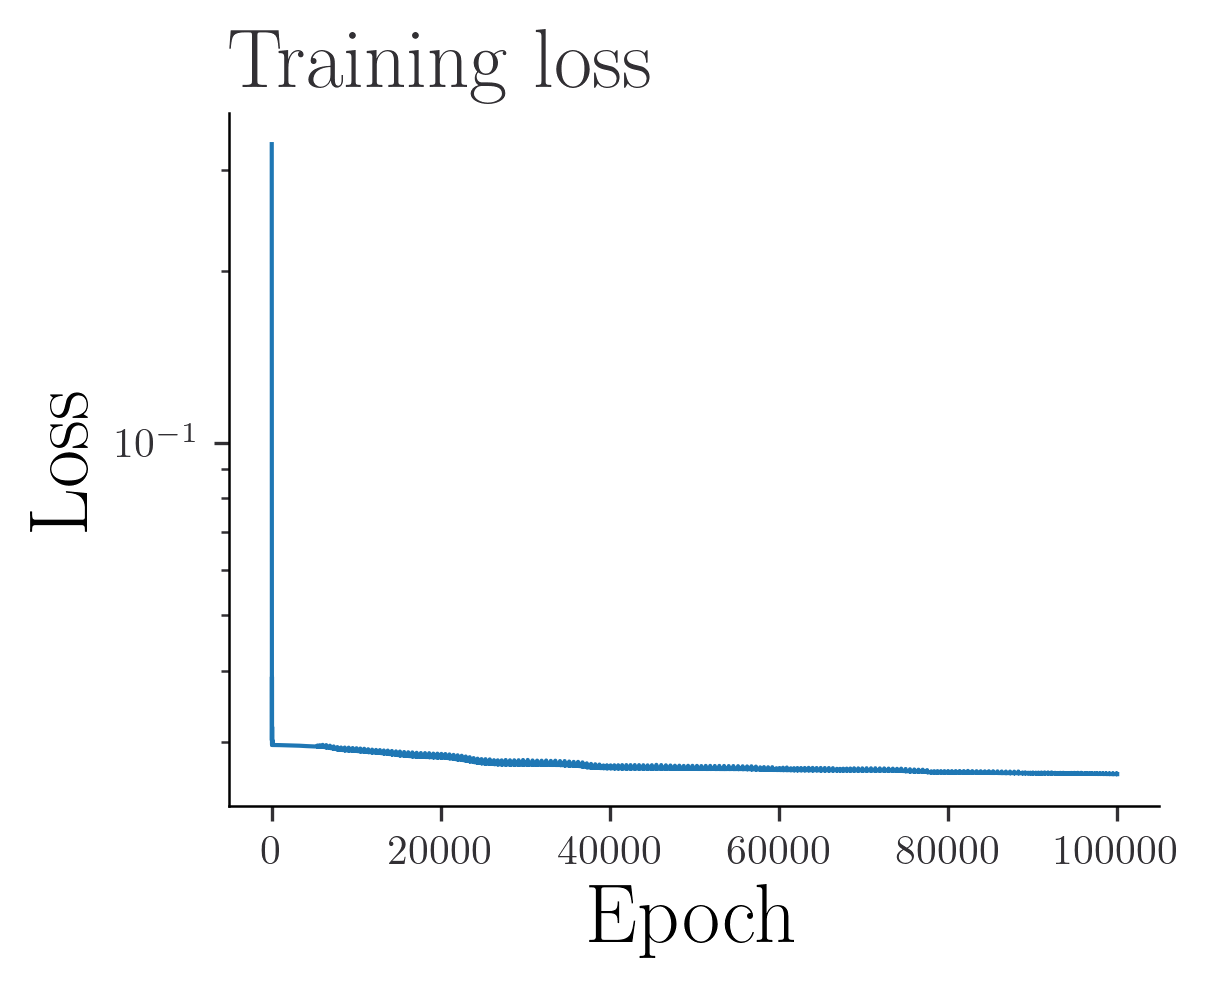

In [44]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

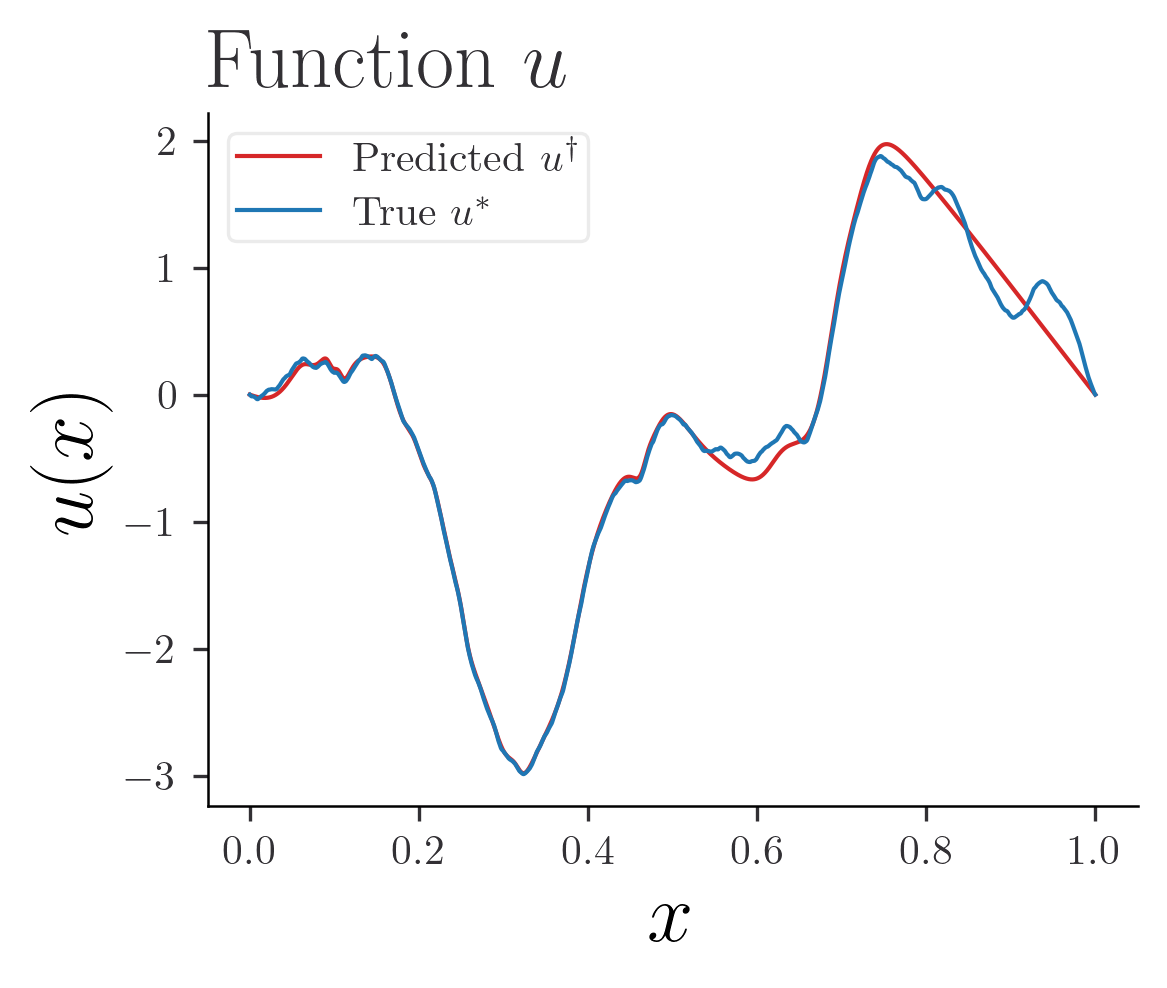

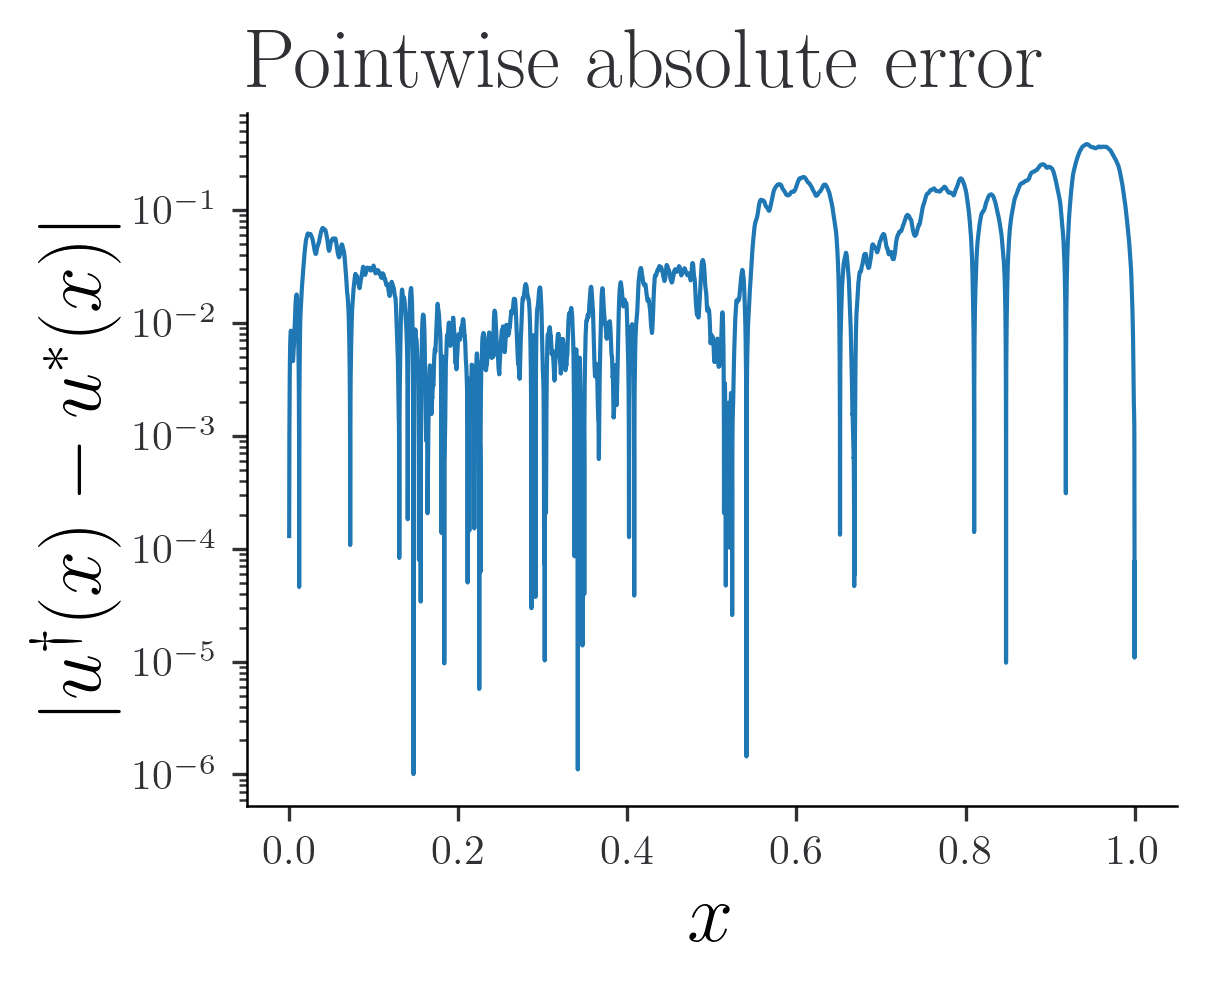

In [45]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


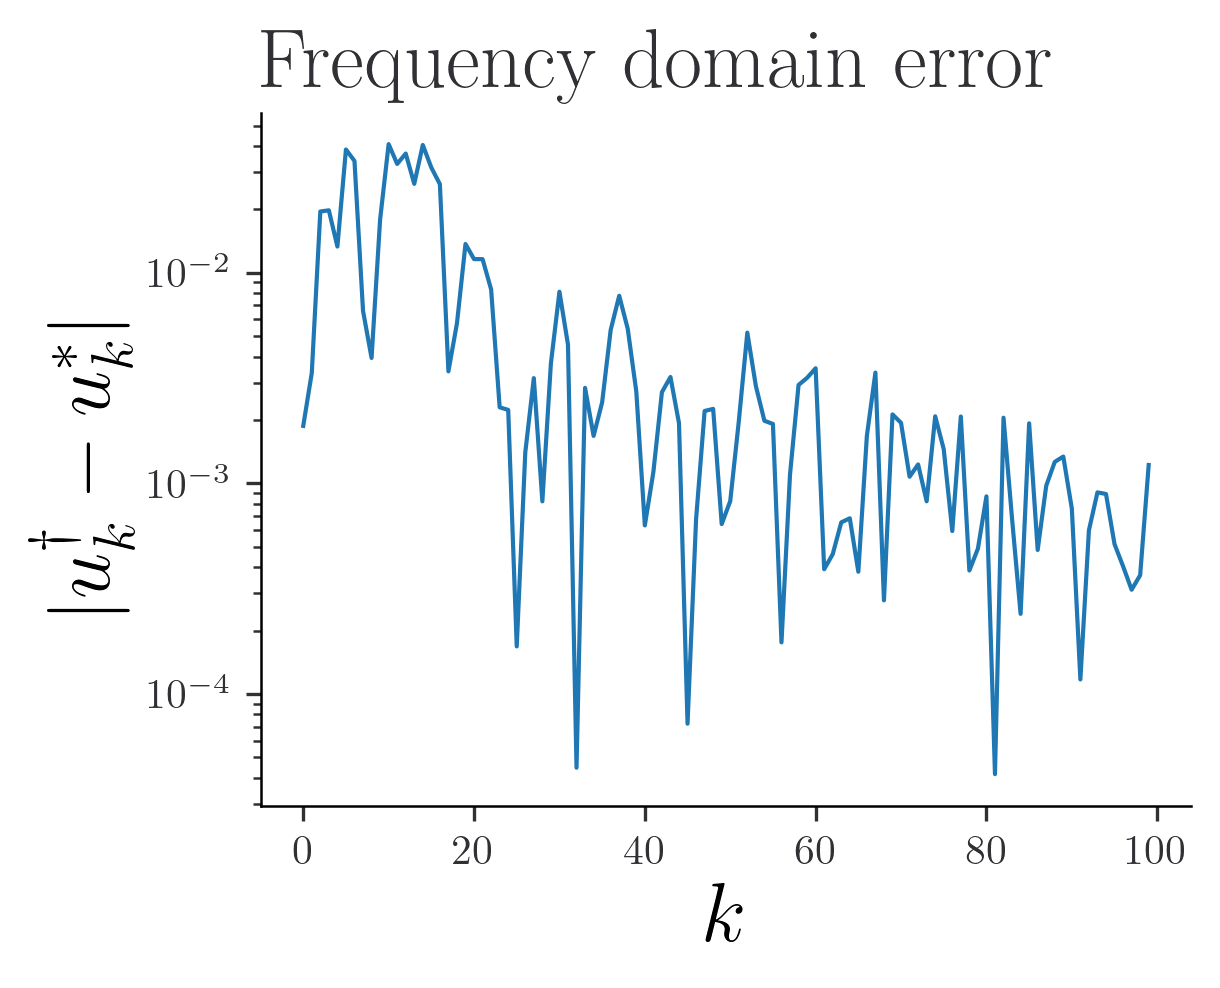

In [46]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

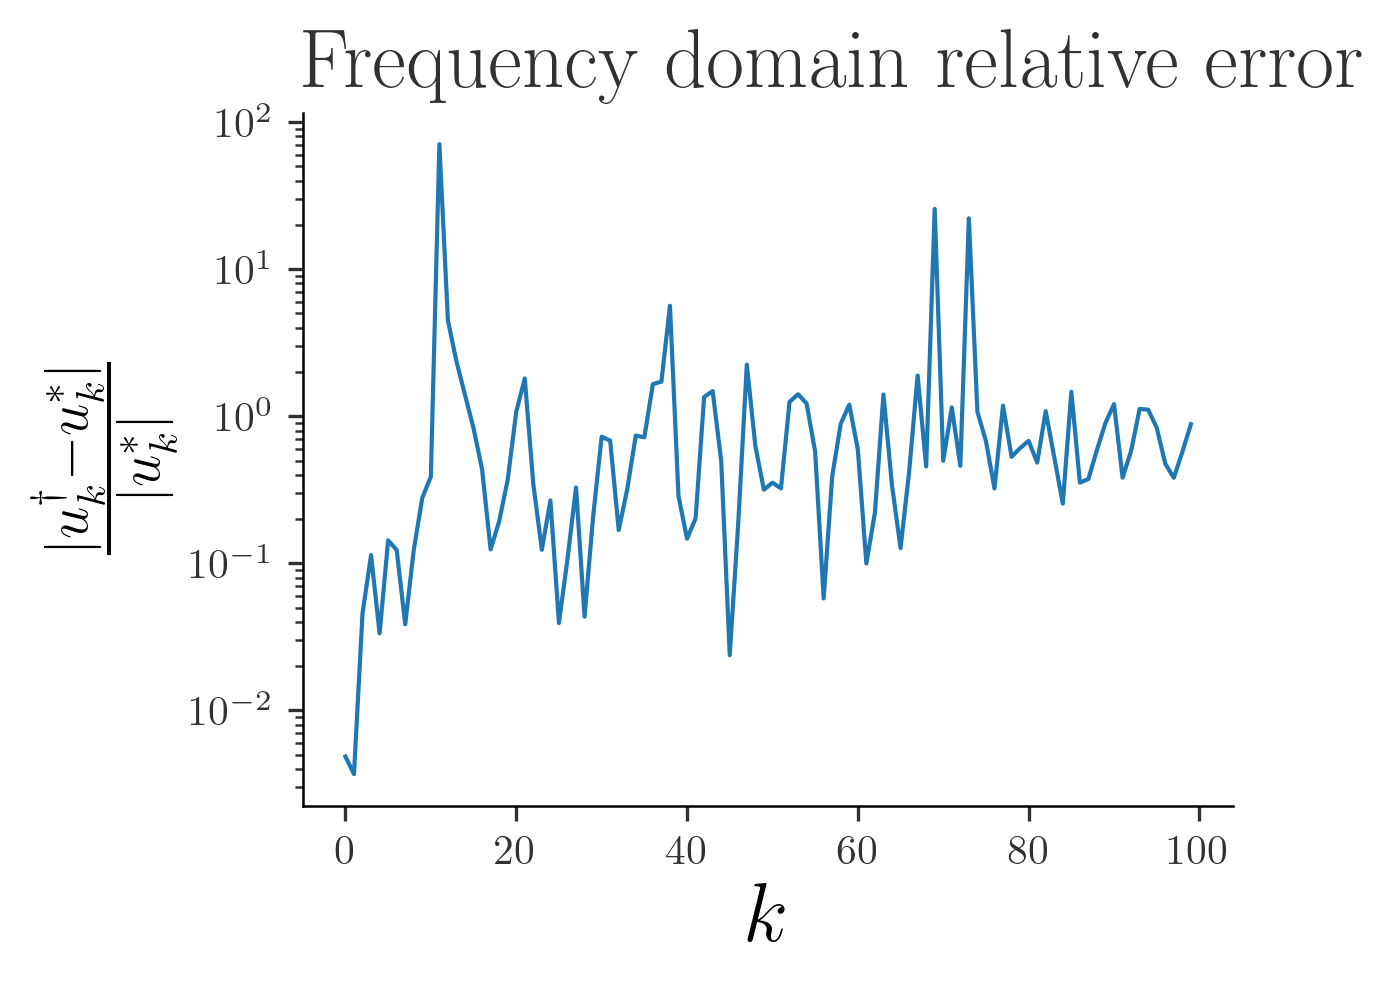

In [47]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements $H^{-3/4}$

In [48]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [49]:
t = 3/4
decay = jnp.arange(1, n_meas+1)**(-t/2)
decay

Array([1.        , 0.77110541, 0.66233778, ..., 0.04420227, 0.04419822,
       0.04419417], dtype=float64, weak_type=True)

In [50]:
layer_sizes = [1, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)*decay

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 1153 parameters in the neural network.


In [51]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [52]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
0.30979485055700917 [(Array([[-6.75489154e-02, -7.02320079e-04,  1.30416868e-02,
        -1.76237053e-04, -3.58088298e-02, -1.38301460e-02,
        -2.55140046e-02,  2.34097574e-01,  4.33025909e-02,
        -1.51187033e-02, -1.09903410e-01,  2.95596499e-02,
        -1.76494487e-04, -2.59552530e-01, -1.17276790e-01,
        -2.10627608e-02, -2.85513367e-04,  1.73903365e-02,
        -9.70147634e-02, -5.72293742e-02,  4.85006682e-02,
         2.18300557e-02, -1.98477739e-01, -5.09917575e-03,
         1.77408674e-01, -1.97355994e-03,  7.18280860e-03,
         1.88702997e-01,  6.24142982e-04,  8.64372690e-02,
         7.66972587e-02, -1.70403390e-02]], dtype=float64), Array([-6.75460579e-02, -6.97124891e-04,  1.30439450e-02, -1.78838361e-04,
       -3.58084407e-02, -1.38293570e-02, -2.55102641e-02,  2.34094655e-01,
        4.32990755e-02, -1.51178077e-02, -1.09908172e-01,  2.95668287e-02,
       -1.77136716e-04, -2.59551882e-01, -1.17272078e-01, -2.10593959e-02,
      

In [53]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [54]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [55]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 0.3097949
Step 0, Training Loss: 0.3097949, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0061238
Step 10000, Training Loss: 0.0061238, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0057921
Step 20000, Training Loss: 0.0057921, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0054055
Step 30000, Training Loss: 0.0054055, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0053025
Step 40000, Training Loss: 0.0053025, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0052904
Step 50000, Training Loss: 0.0052904, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0052325
Step 60000, Training Loss: 0.0052325, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0051694
Step 70000, Training Loss: 0.0051694, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0051561
Step 80000, Training Loss: 0.0051561, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0051323
Step 90000, Training Loss: 0.0051323, Learning Rate: 0.000387


In [56]:
pred = neural_network(params, domain_finest)

In [57]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

0.10765196652655865 0.08650339871862808


In [58]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(0.10765197, dtype=float64), Array(0.0865034, dtype=float64))

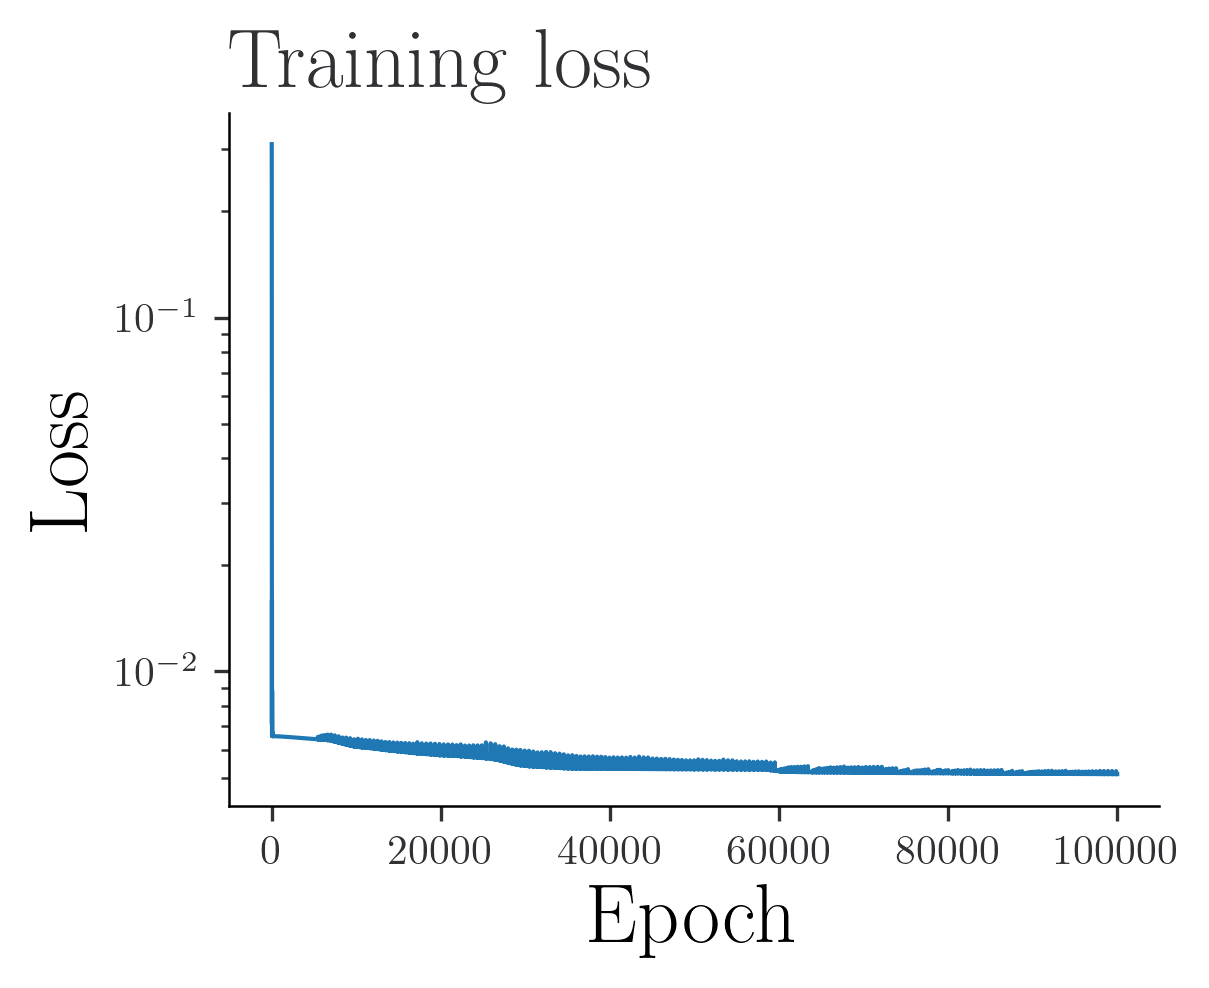

In [59]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

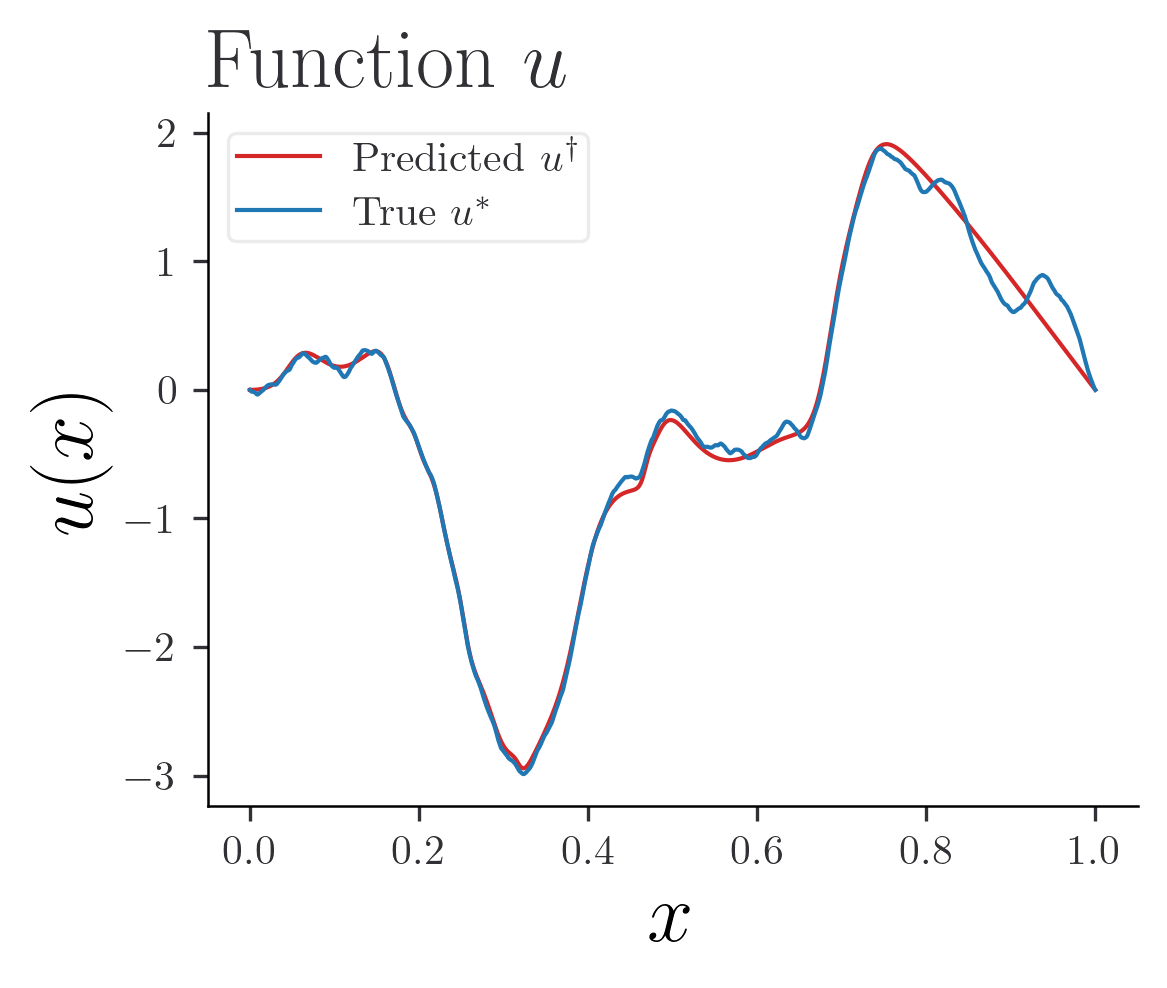

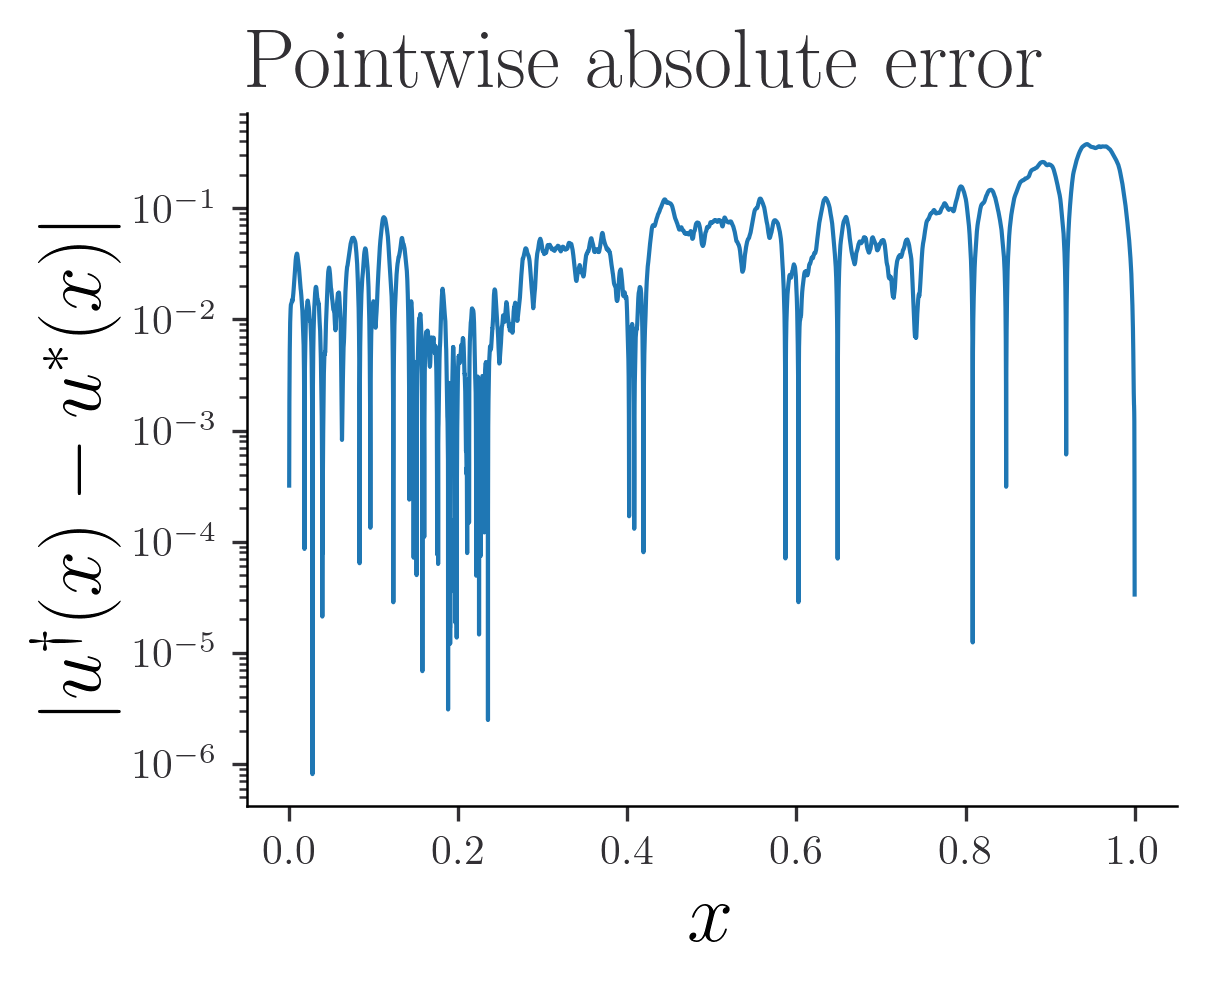

In [63]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


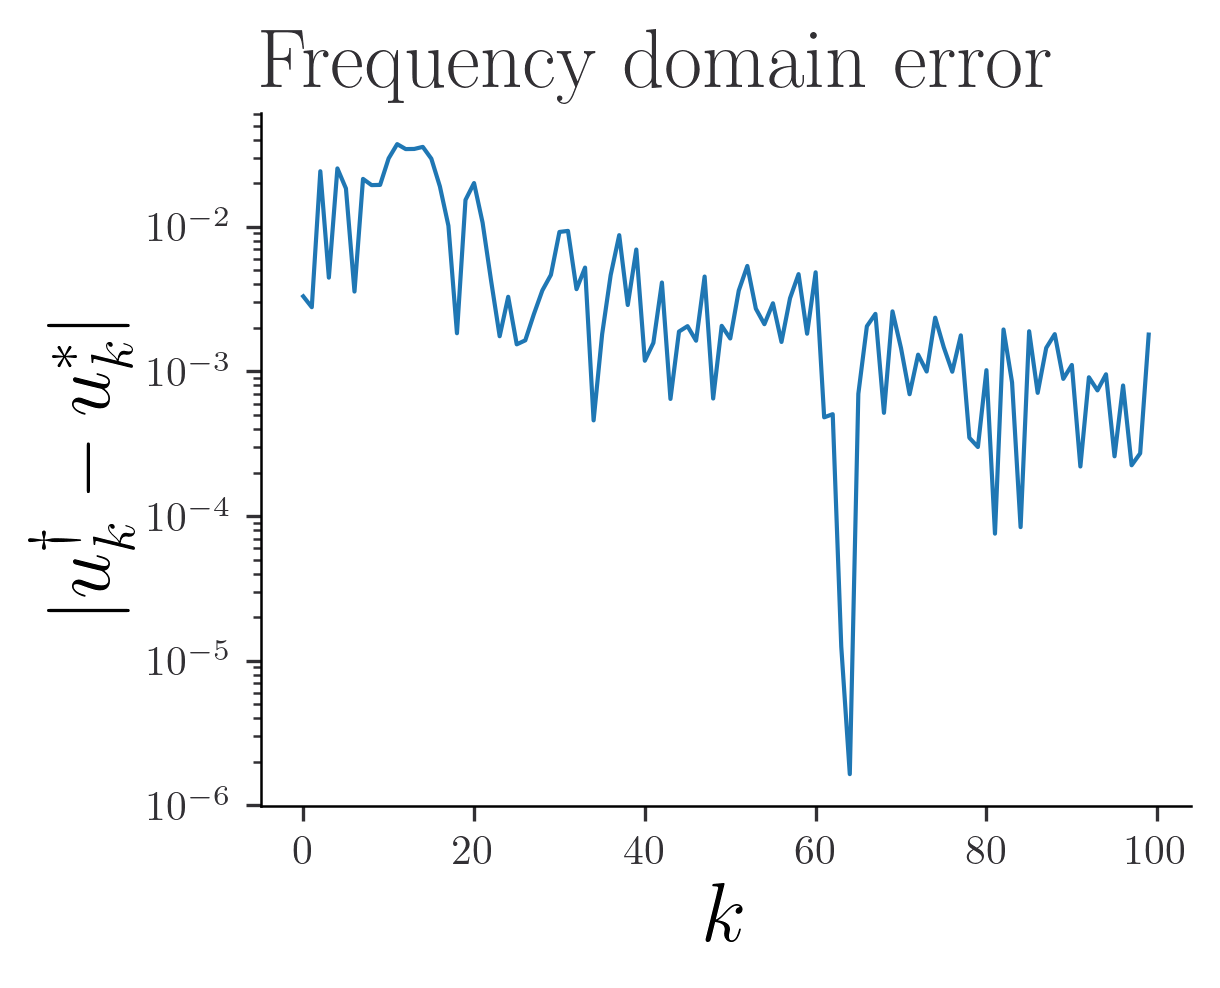

In [64]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

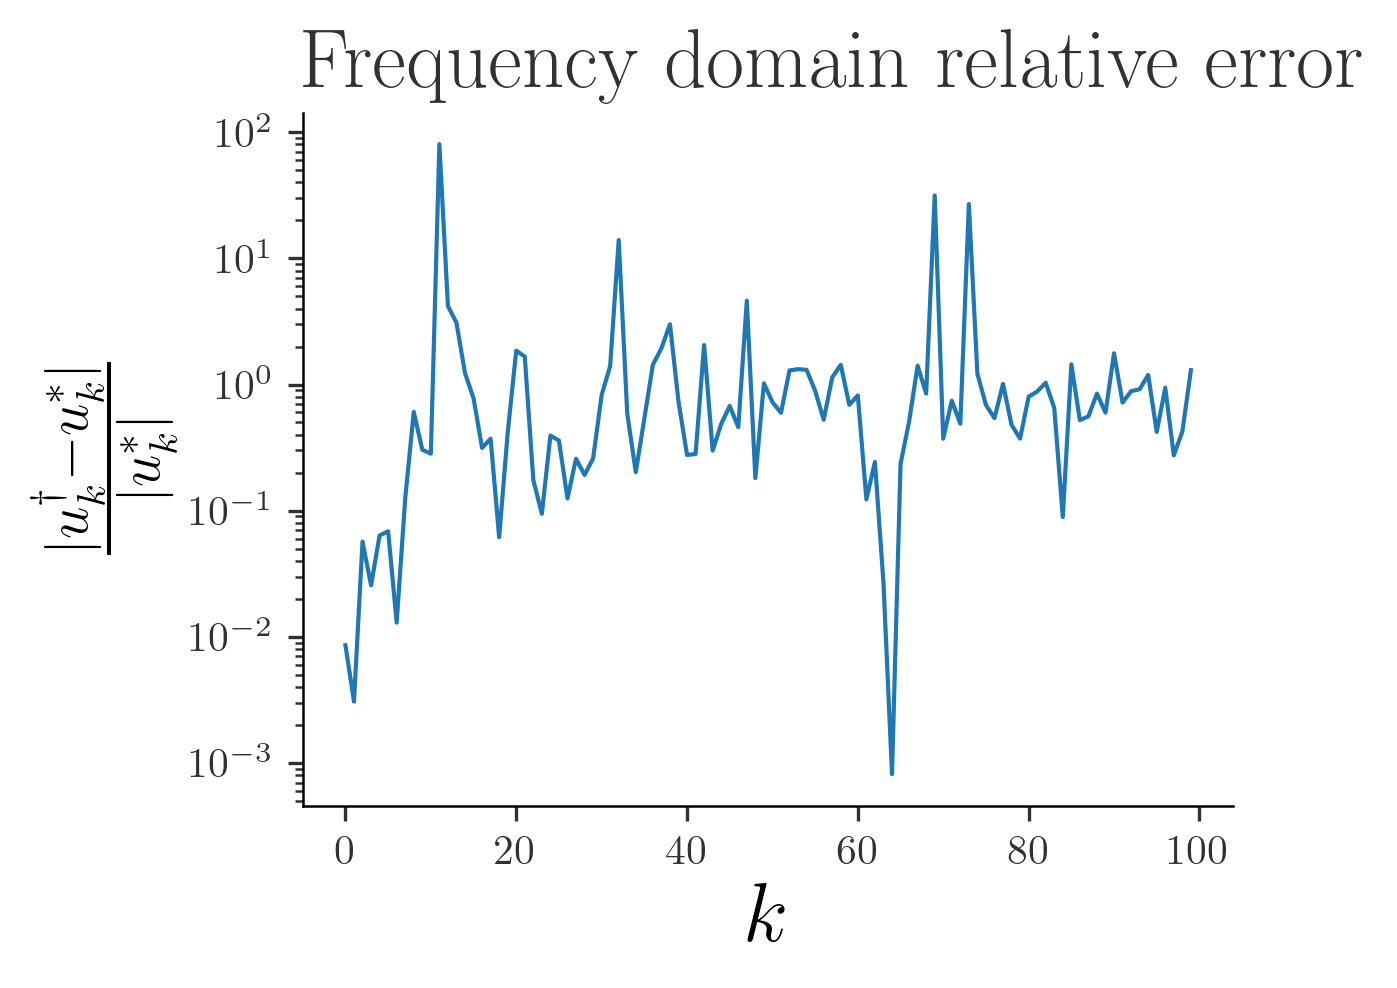

In [65]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements $H^{-1}$

In [66]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [67]:
t = 1
decay = jnp.arange(1, n_meas+1)**(-t/2)
decay

Array([1.        , 0.70710678, 0.57735027, ..., 0.01562882, 0.01562691,
       0.015625  ], dtype=float64, weak_type=True)

In [68]:
layer_sizes = [1, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)*decay

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 1153 parameters in the neural network.


In [69]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [70]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
0.305169948281883 [(Array([[-6.75465700e-02, -7.02897340e-04,  1.30412125e-02,
        -1.76293470e-04, -3.58077677e-02, -1.38295962e-02,
        -2.55134897e-02,  2.34090553e-01,  4.33016295e-02,
        -1.51184186e-02, -1.09899555e-01,  2.95585016e-02,
        -1.76805725e-04, -2.59544329e-01, -1.17272904e-01,
        -2.10622123e-02, -2.85498151e-04,  1.73920223e-02,
        -9.70114749e-02, -5.72274587e-02,  4.84999908e-02,
         2.18291452e-02, -1.98471498e-01, -5.09913747e-03,
         1.77402738e-01, -1.97379405e-03,  7.18301829e-03,
         1.88697264e-01,  6.23609931e-04,  8.64343998e-02,
         7.66944737e-02, -1.70411540e-02]], dtype=float64), Array([-6.75447797e-02, -6.98848721e-04,  1.30422330e-02, -1.77637910e-04,
       -3.58077110e-02, -1.38293495e-02, -2.55102137e-02,  2.34088368e-01,
        4.32980999e-02, -1.51172935e-02, -1.09903371e-01,  2.95638181e-02,
       -1.76628553e-04, -2.59544055e-01, -1.17269611e-01, -2.10596471e-02,
       -

In [71]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [72]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [73]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 0.3051699
Step 0, Training Loss: 0.3051699, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0016358
Step 10000, Training Loss: 0.0016358, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0014458
Step 20000, Training Loss: 0.0014458, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0012510
Step 30000, Training Loss: 0.0012510, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0011945
Step 40000, Training Loss: 0.0011945, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0011565
Step 50000, Training Loss: 0.0011565, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0011382
Step 60000, Training Loss: 0.0011382, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0011309
Step 70000, Training Loss: 0.0011309, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0011710
Step 80000, Training Loss: 0.0011710, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0011127
Step 90000, Training Loss: 0.0011127, Learning Rate: 0.000387


In [74]:
pred = neural_network(params, domain_finest)

In [75]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

0.10471407240556597 0.08414266314879858


In [76]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(0.10471407, dtype=float64), Array(0.08414266, dtype=float64))

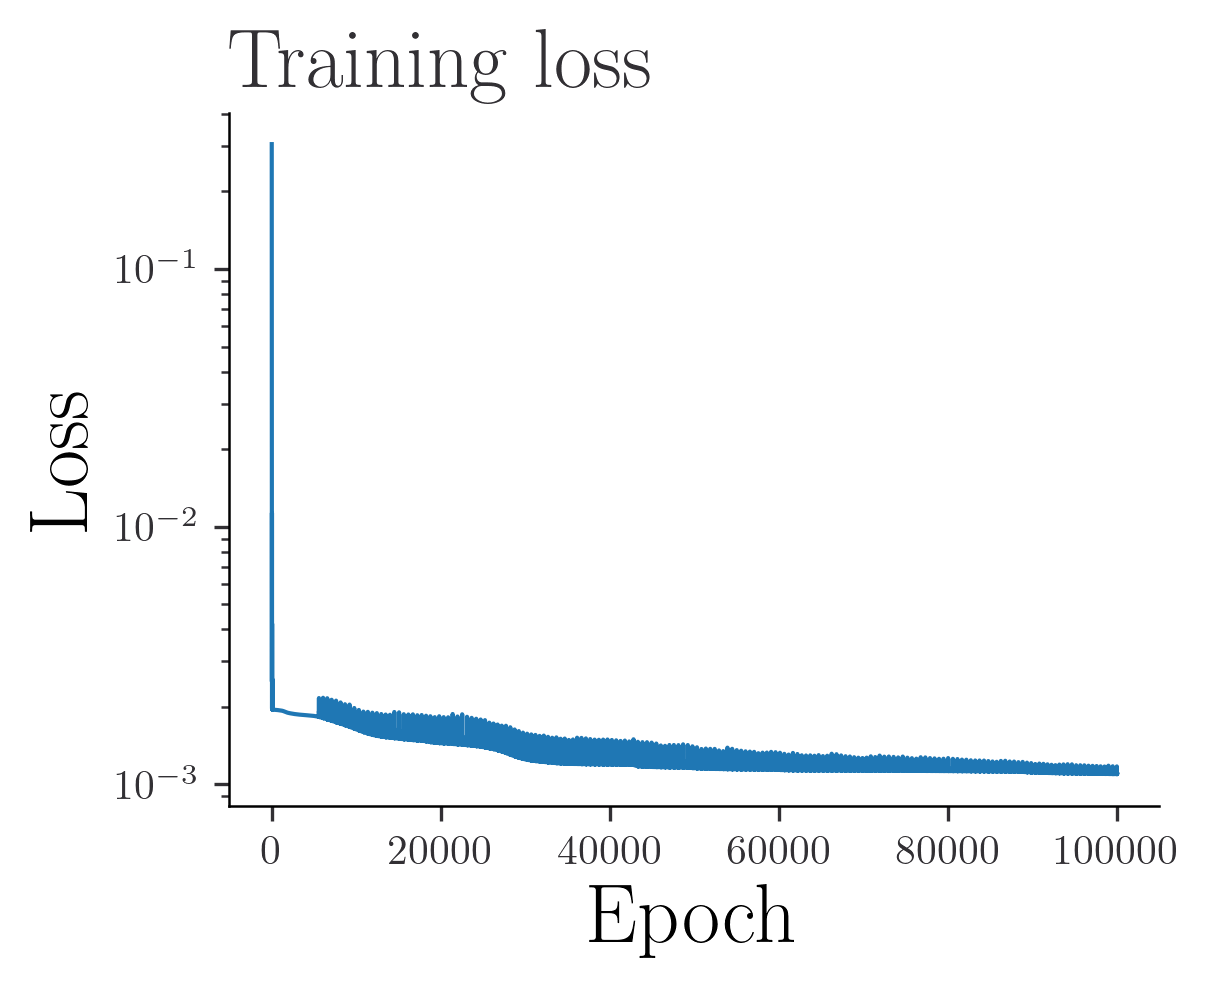

In [77]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

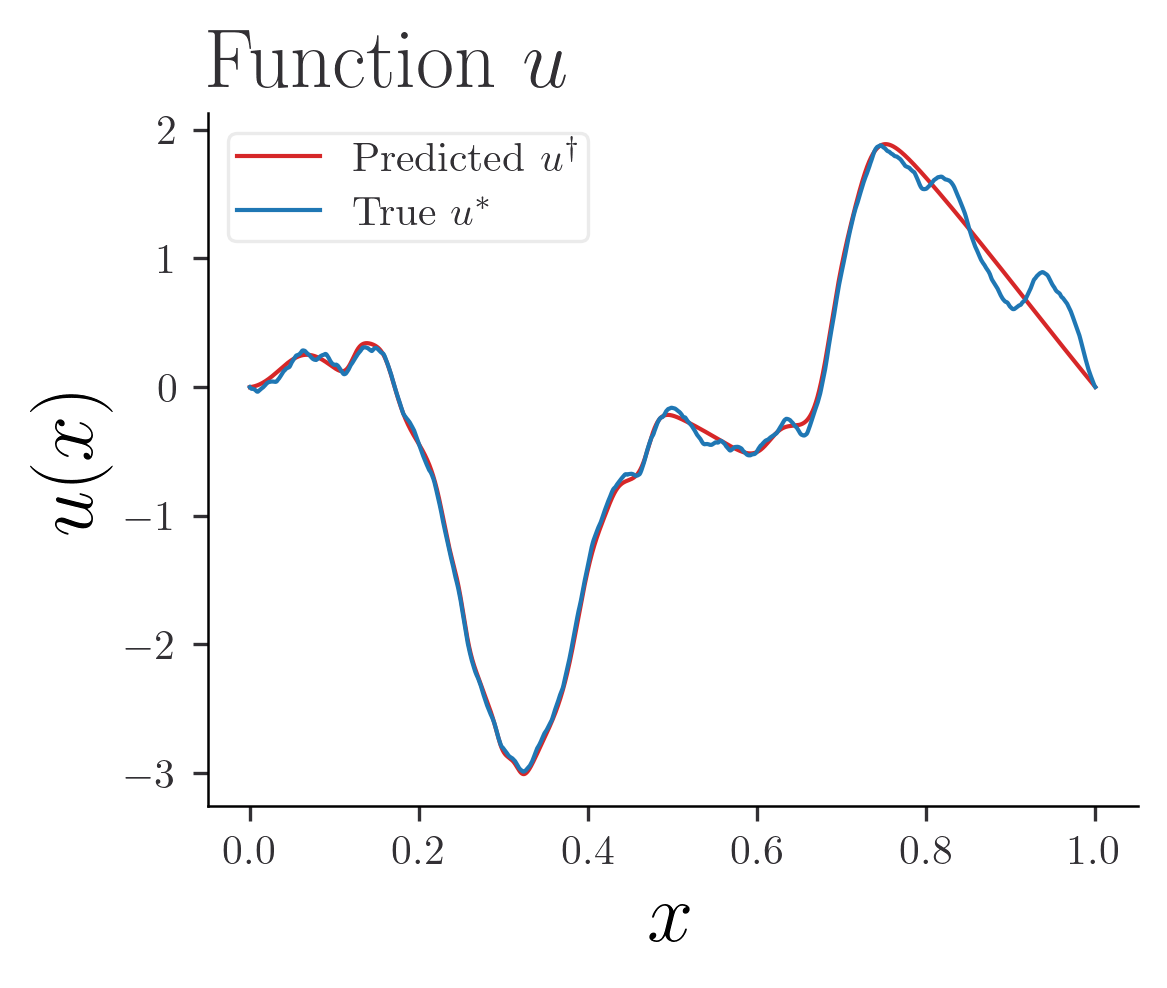

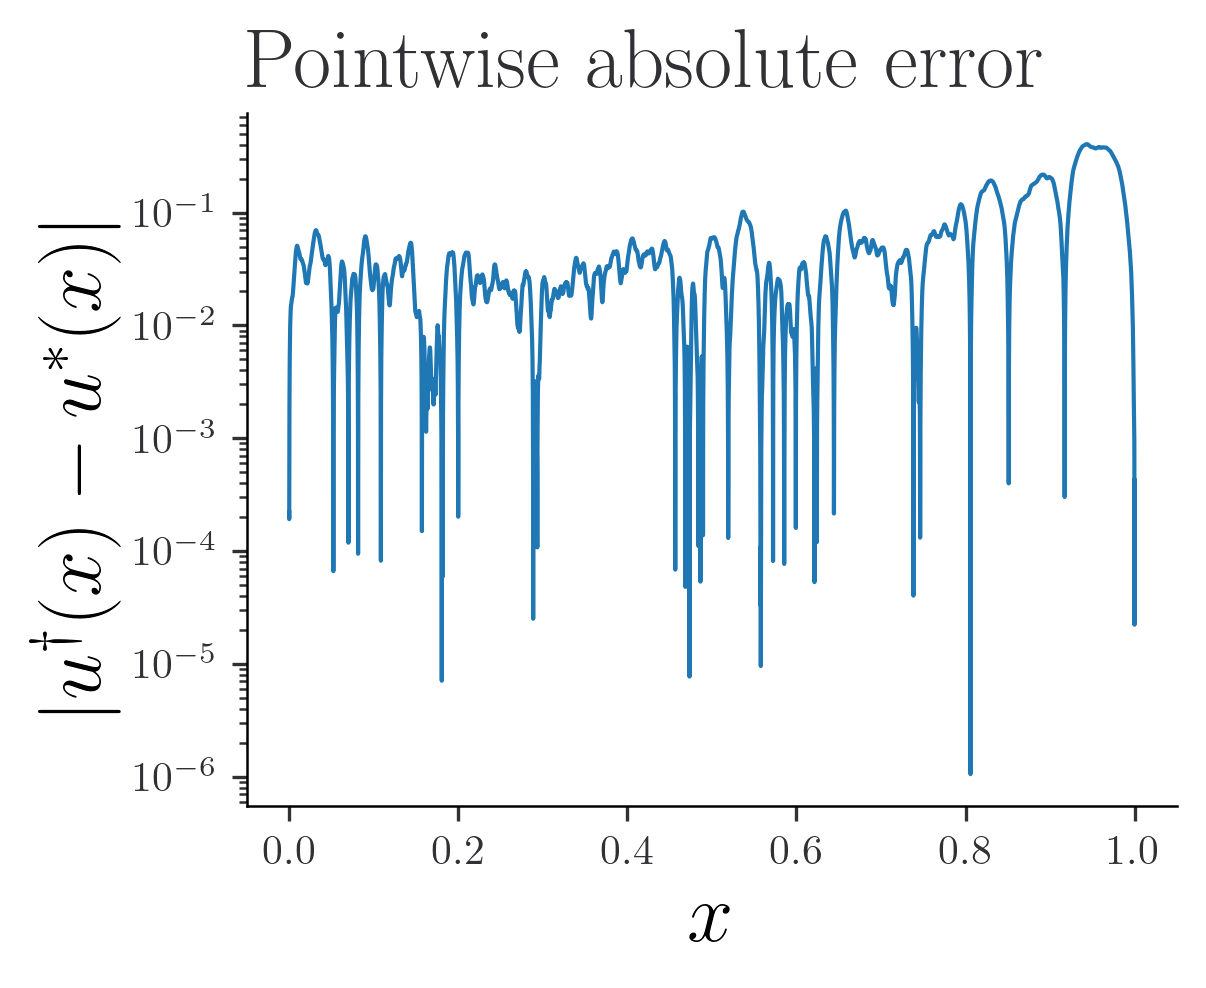

In [78]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


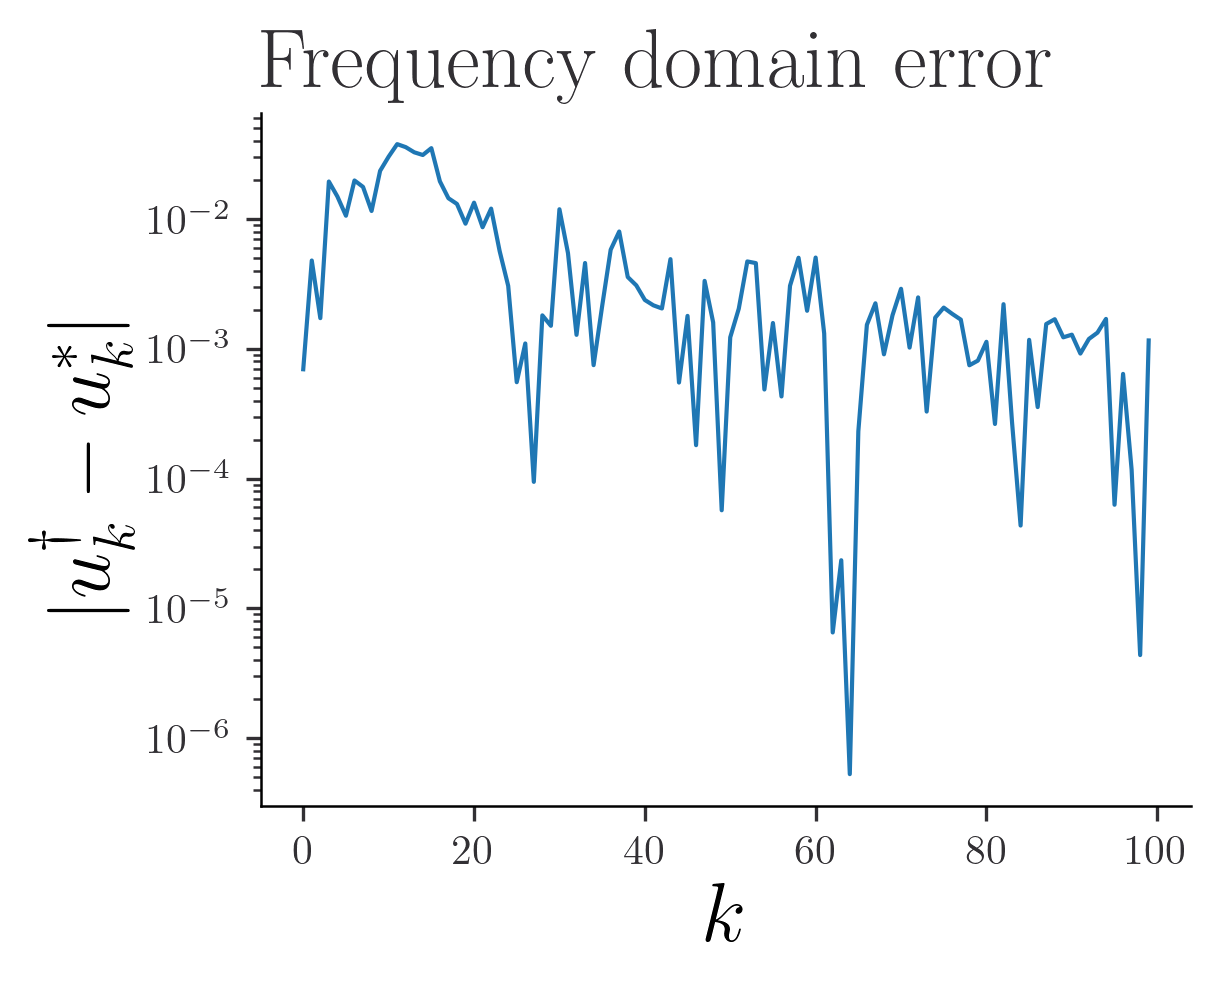

In [79]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

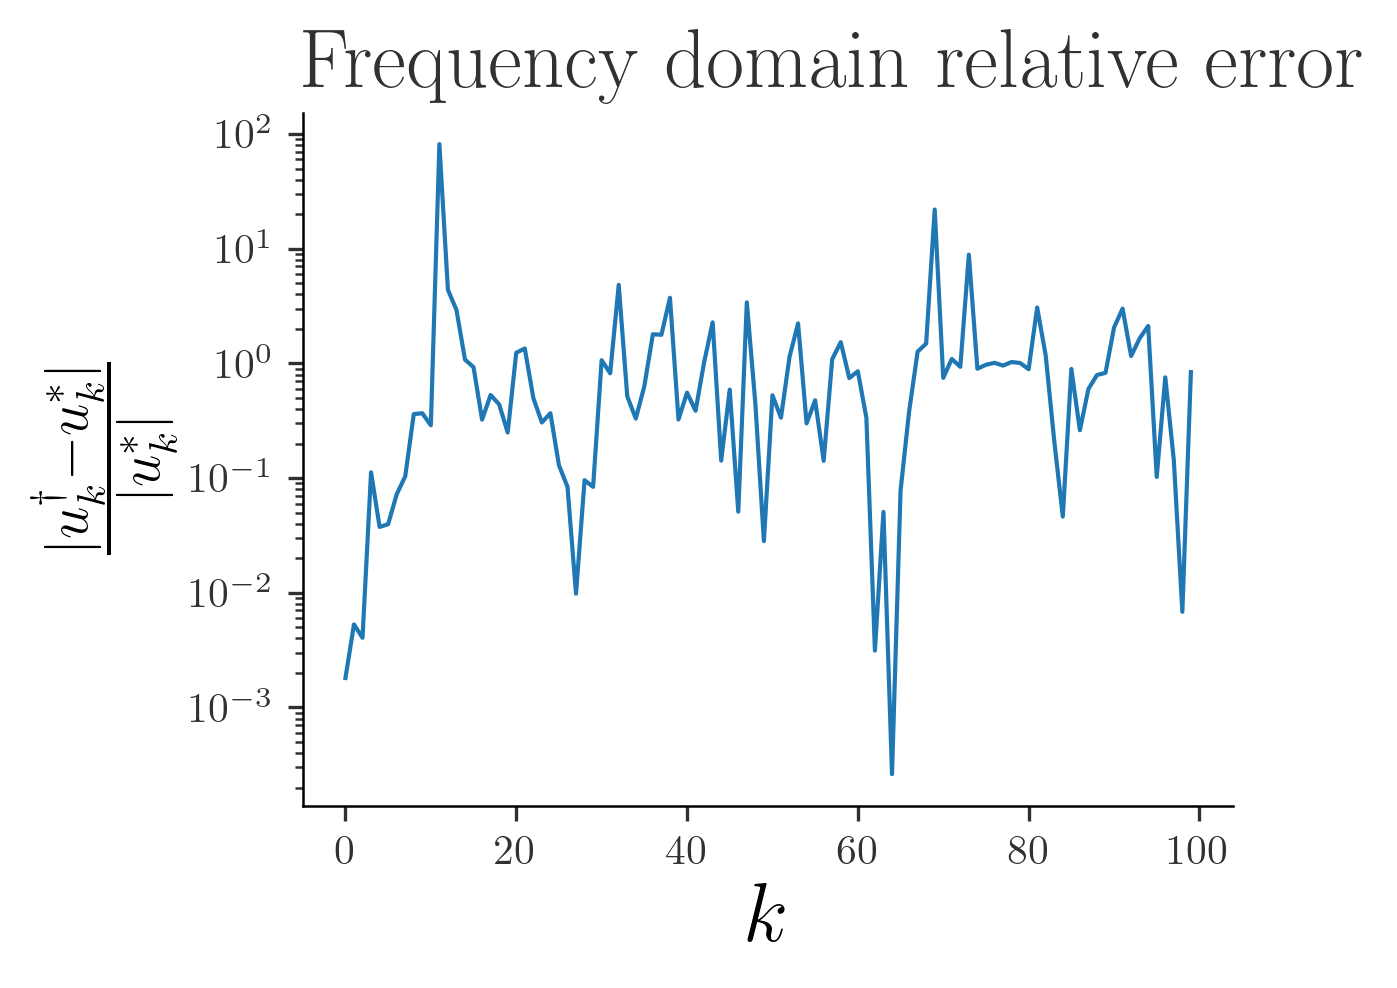

In [80]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 pointwise

In [39]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [41]:
layer_sizes = [1, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred =-nu*laplacian_grid + u_grid
    residual_interior = (pred - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 1153 parameters in the neural network.


In [42]:
ratio = int(n_coef/n_meas)
f_observed =  f_values[::ratio]
f_observed.shape

(4096,)

In [43]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
16566.8714798466 [(Array([[-0.27476521,  0.12799837,  0.12785488, -0.06551848, -0.10561561,
        -0.01311075, -0.12427169,  0.94845188,  0.19712649, -0.03784708,
        -0.54064215,  0.20961168, -0.02940882, -1.09693859, -0.47426656,
        -0.04496949, -0.11480972,  0.025159  , -0.44416181, -0.31256193,
         0.24414224,  0.15368832, -0.82440988,  0.01086308,  0.69413606,
        -0.02230104,  0.00265732,  0.69572515, -0.00846487,  0.38411093,
         0.34076658, -0.02276806]], dtype=float64), Array([-0.29205111,  0.21821763,  0.50040849, -0.3511917 , -0.06143472,
        0.12353071, -0.35980917,  1.4887482 ,  0.64031136, -0.23334411,
       -0.81556404,  0.41129514, -0.29528973, -1.67088973, -0.63859313,
       -0.06599515, -0.49036223,  0.96309344, -0.69936754, -0.7328663 ,
        0.94472531,  0.24979915, -1.32681971,  0.04881623,  0.60815057,
       -0.3211835 ,  0.23884479,  0.87479562, -0.29559611,  0.64296484,
        0.43708358, -0.63804522], dty

In [44]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [45]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [46]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 16566.8714798
Step 0, Training Loss: 16566.8714798, Learning Rate: 0.001000
Epoch 10000, Loss: 16058.2839763
Step 10000, Training Loss: 16058.2839763, Learning Rate: 0.000900
Epoch 20000, Loss: 16027.7457092
Step 20000, Training Loss: 16027.7457092, Learning Rate: 0.000810
Epoch 30000, Loss: 16020.7964528
Step 30000, Training Loss: 16020.7964528, Learning Rate: 0.000729
Epoch 40000, Loss: 16020.2283200
Step 40000, Training Loss: 16020.2283200, Learning Rate: 0.000656
Epoch 50000, Loss: 16020.0348758
Step 50000, Training Loss: 16020.0348758, Learning Rate: 0.000590
Epoch 60000, Loss: 16019.9579629
Step 60000, Training Loss: 16019.9579629, Learning Rate: 0.000531
Epoch 70000, Loss: 16019.7034814
Step 70000, Training Loss: 16019.7034814, Learning Rate: 0.000478
Epoch 80000, Loss: 16019.6291700
Step 80000, Training Loss: 16019.6291700, Learning Rate: 0.000430
Epoch 90000, Loss: 16019.3803164
Step 90000, Training Loss: 16019.3803164, Learning Rate: 0.000387


In [47]:
pred = neural_network(params, domain_finest)

In [48]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

2.0018883473965743 1.6086110778319946


In [49]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(2.00188402, dtype=float64), Array(1.6086076, dtype=float64))

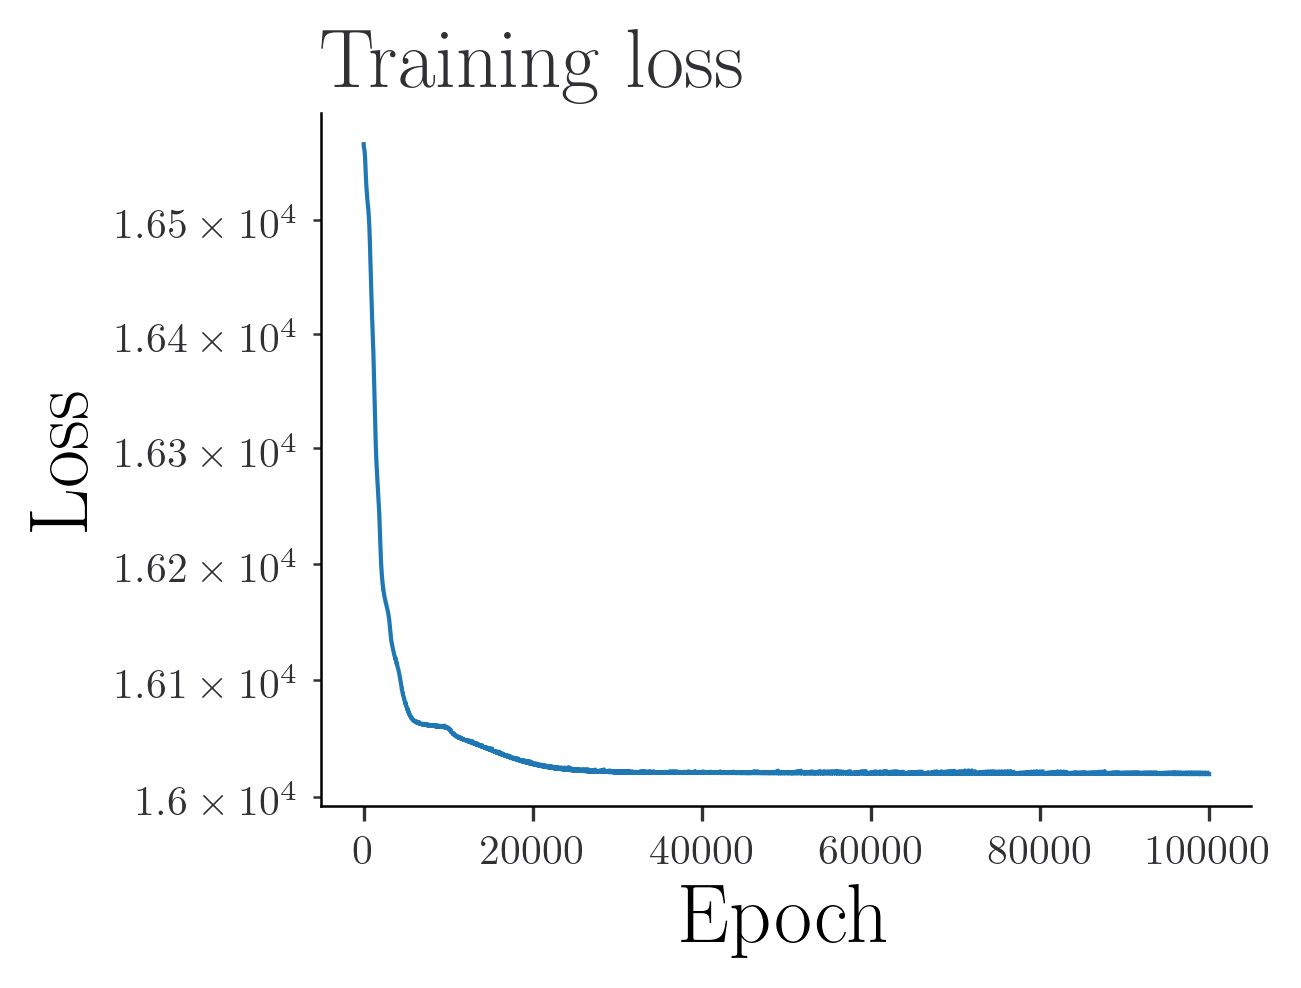

In [61]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

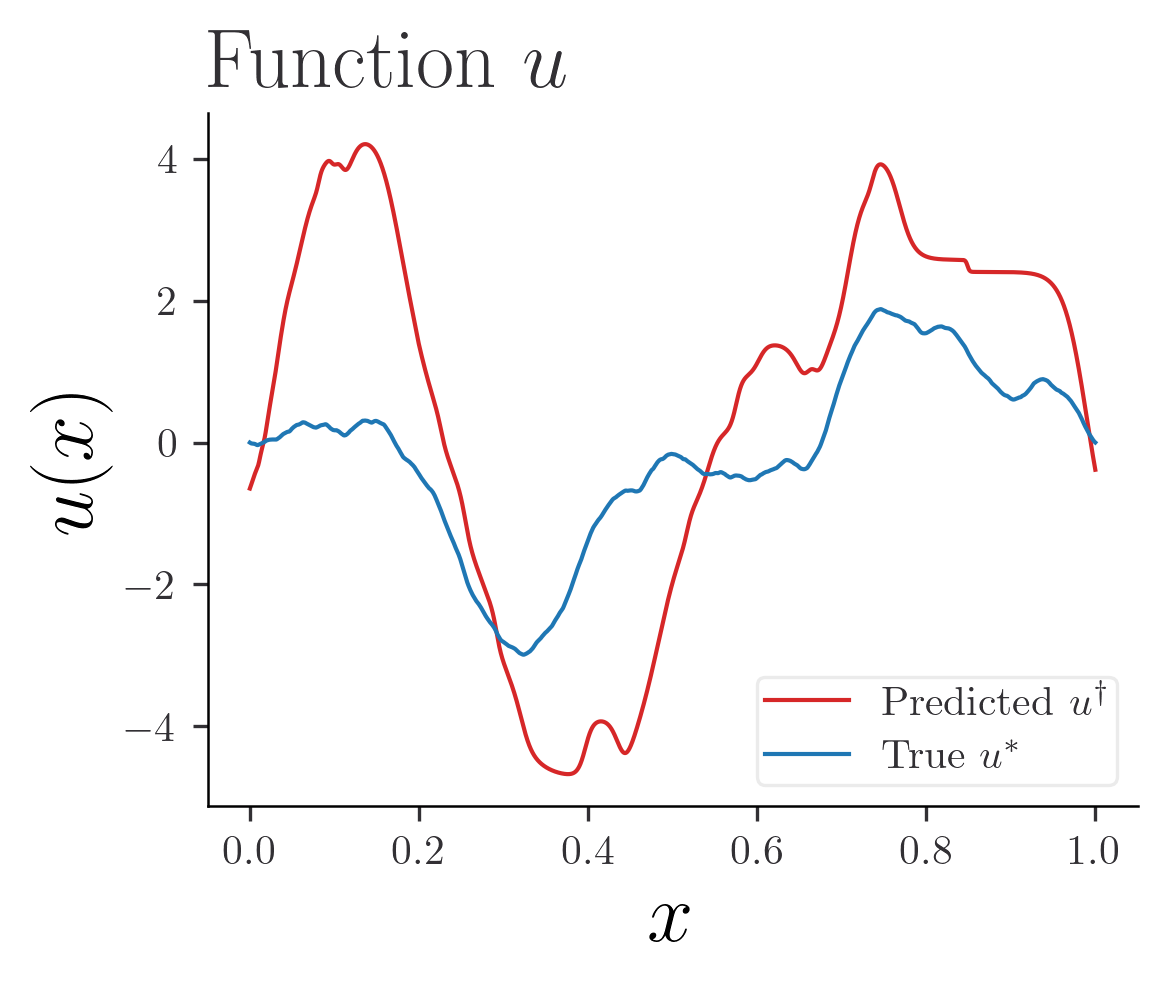

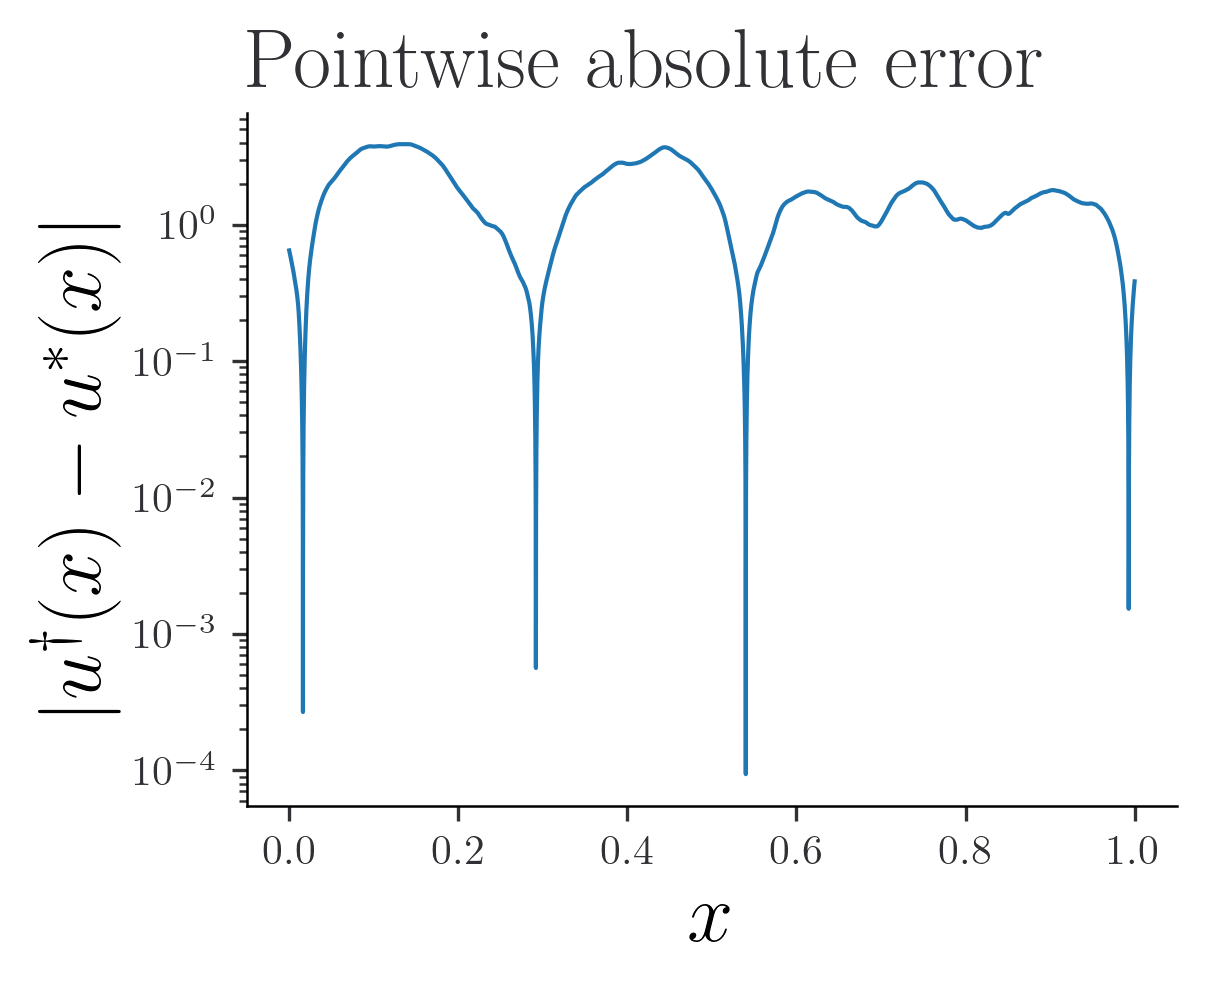

In [62]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


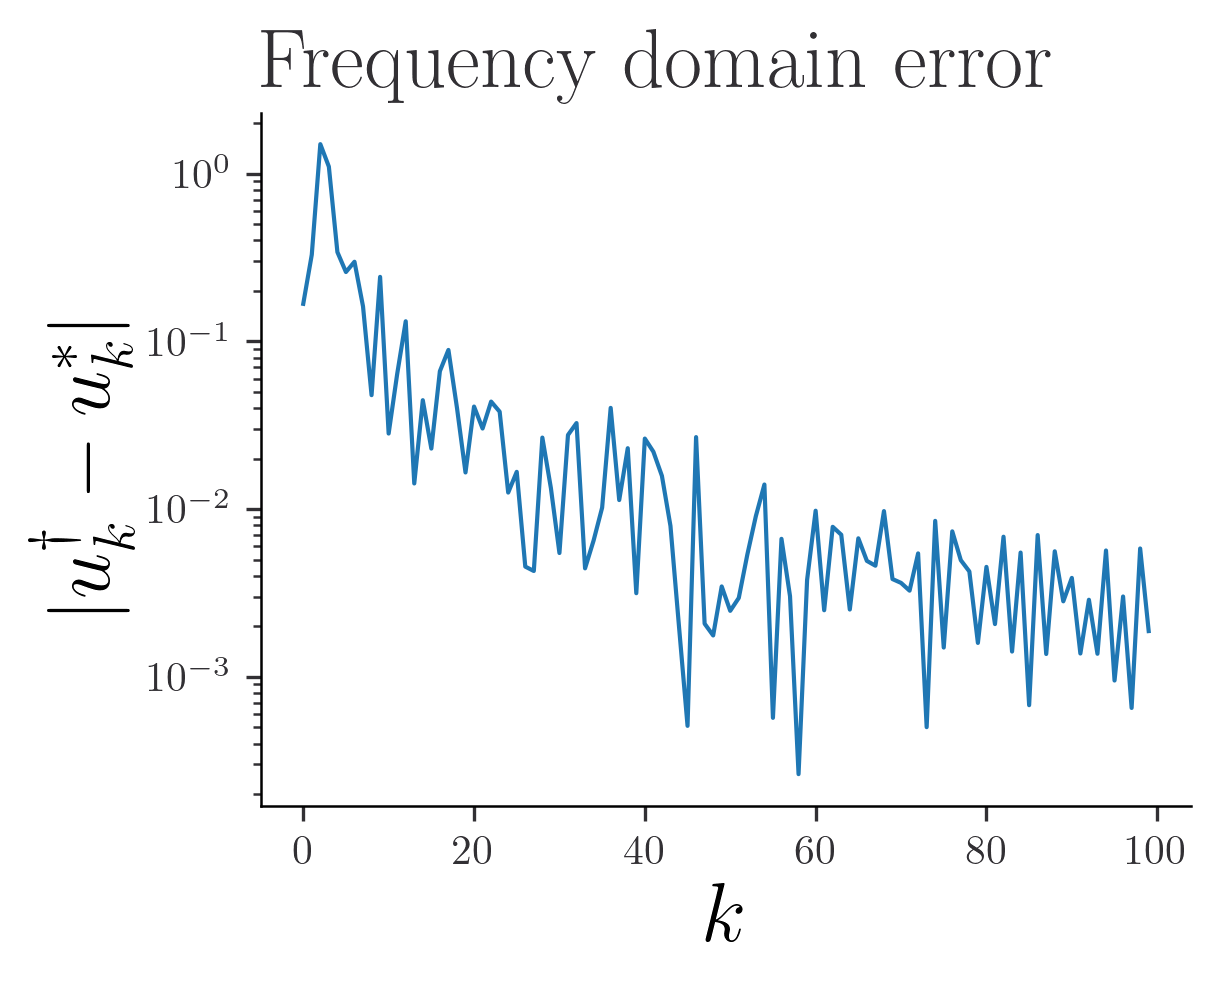

In [63]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

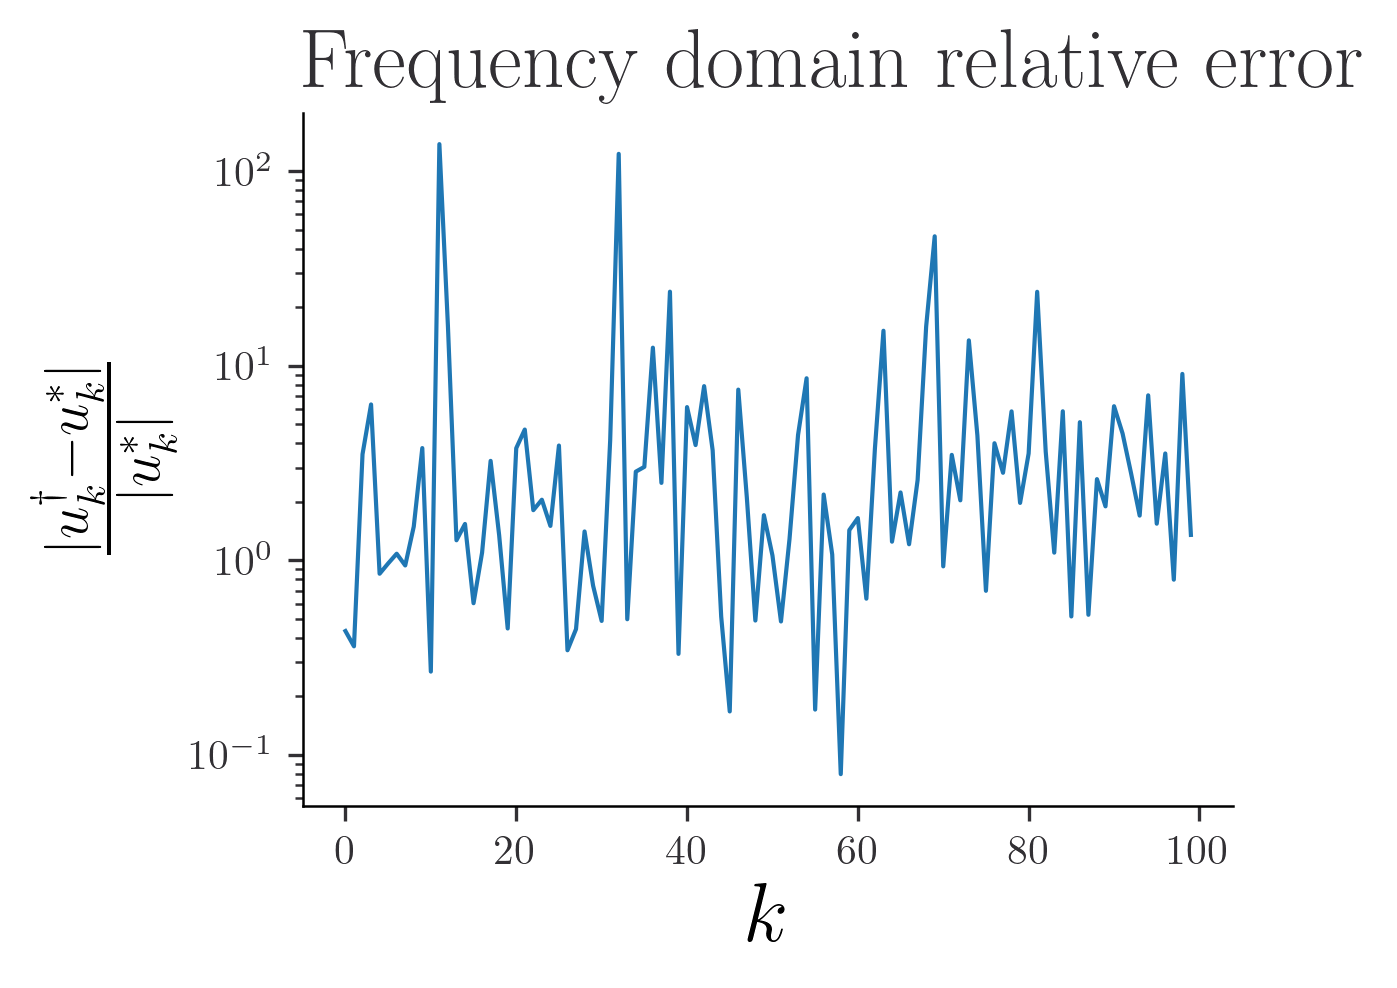

In [64]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements + RFF $L^2$

In [138]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [139]:
# Draw random samples for the RF part
n_samples = 32
print('Number of samples: ', n_samples)
d_in = 1

key = random.PRNGKey(0)
key, subkey = random.split(key)
sigma_rff = 1.0
random_features = random.normal(subkey, shape = (n_samples, d_in))*sigma_rff

def feature_map(x, random_features):
    n_samples = random_features.shape[0]
    outputs = jnp.dot(random_features, x)
    return jnp.squeeze((1/jnp.sqrt(n_samples))*jnp.vstack([jnp.cos(outputs), jnp.sin(outputs)]))


def predict(params, x):
    activations = x
    # First pass through the feature map
    activations = feature_map(activations, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

Number of samples:  32


In [140]:
layer_sizes = [n_samples*2, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 3169 parameters in the neural network.


In [141]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [142]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
1.0436069380473851 [(Array([[ 1.13139632e-02, -1.68791852e-02, -1.87115791e-02, ...,
        -2.38208838e-02, -2.91220092e-03,  2.59531509e-02],
       [ 1.17787666e-02, -1.75895650e-02, -1.93621281e-02, ...,
        -2.46397063e-02, -3.05823148e-03,  2.68116486e-02],
       [ 1.05343096e-02, -1.56877923e-02, -1.76200257e-02, ...,
        -2.24470151e-02, -2.66732572e-03,  2.45124076e-02],
       ...,
       [-5.85897048e-04,  8.95181168e-04,  8.20663139e-04, ...,
         1.03293177e-03,  1.83867246e-04, -1.08343911e-03],
       [ 5.80986311e-04, -8.87680261e-04, -8.13780033e-04, ...,
        -1.02426842e-03, -1.82327605e-04,  1.07434862e-03],
       [-6.99385623e-05,  1.06865775e-04,  9.79451841e-05, ...,
         1.23279655e-04,  2.19536471e-05, -1.29294372e-04]],      dtype=float64), Array([ 0.0667847 , -0.09973688, -0.10974418,  0.08039896, -0.04944843,
       -0.06927849,  0.13118807, -0.18018201, -0.14456408,  0.00344194,
        0.11142332, -0.01707402,  0

In [143]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [144]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [145]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 1.0436069
Step 0, Training Loss: 1.0436069, Learning Rate: 0.001000
Epoch 10000, Loss: 0.9778212
Step 10000, Training Loss: 0.9778212, Learning Rate: 0.000900
Epoch 20000, Loss: 0.9723547
Step 20000, Training Loss: 0.9723547, Learning Rate: 0.000810
Epoch 30000, Loss: 0.9663163
Step 30000, Training Loss: 0.9663163, Learning Rate: 0.000729
Epoch 40000, Loss: 0.9642406
Step 40000, Training Loss: 0.9642406, Learning Rate: 0.000656
Epoch 50000, Loss: 0.9628532
Step 50000, Training Loss: 0.9628532, Learning Rate: 0.000590
Epoch 60000, Loss: 0.9608838
Step 60000, Training Loss: 0.9608838, Learning Rate: 0.000531
Epoch 70000, Loss: 0.9568188
Step 70000, Training Loss: 0.9568188, Learning Rate: 0.000478
Epoch 80000, Loss: 0.9546292
Step 80000, Training Loss: 0.9546292, Learning Rate: 0.000430
Epoch 90000, Loss: 0.9529724
Step 90000, Training Loss: 0.9529724, Learning Rate: 0.000387


In [146]:
pred = neural_network(params, domain_finest)

In [147]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

0.107326226188655 0.08624165109582485


In [ ]:
0.08624165109582485

In [148]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(0.10732623, dtype=float64), Array(0.08624165, dtype=float64))

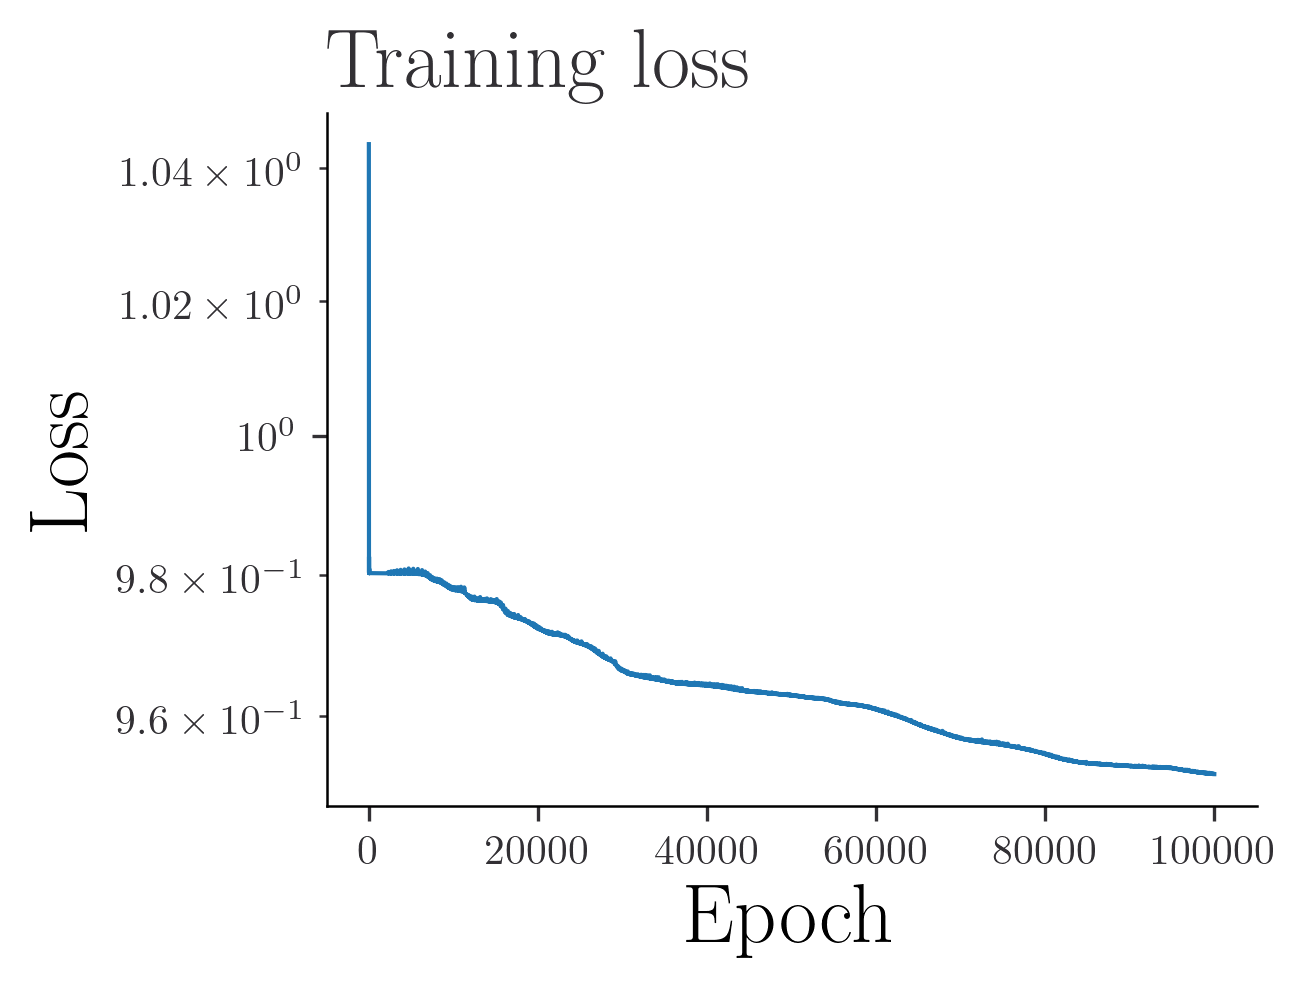

In [149]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

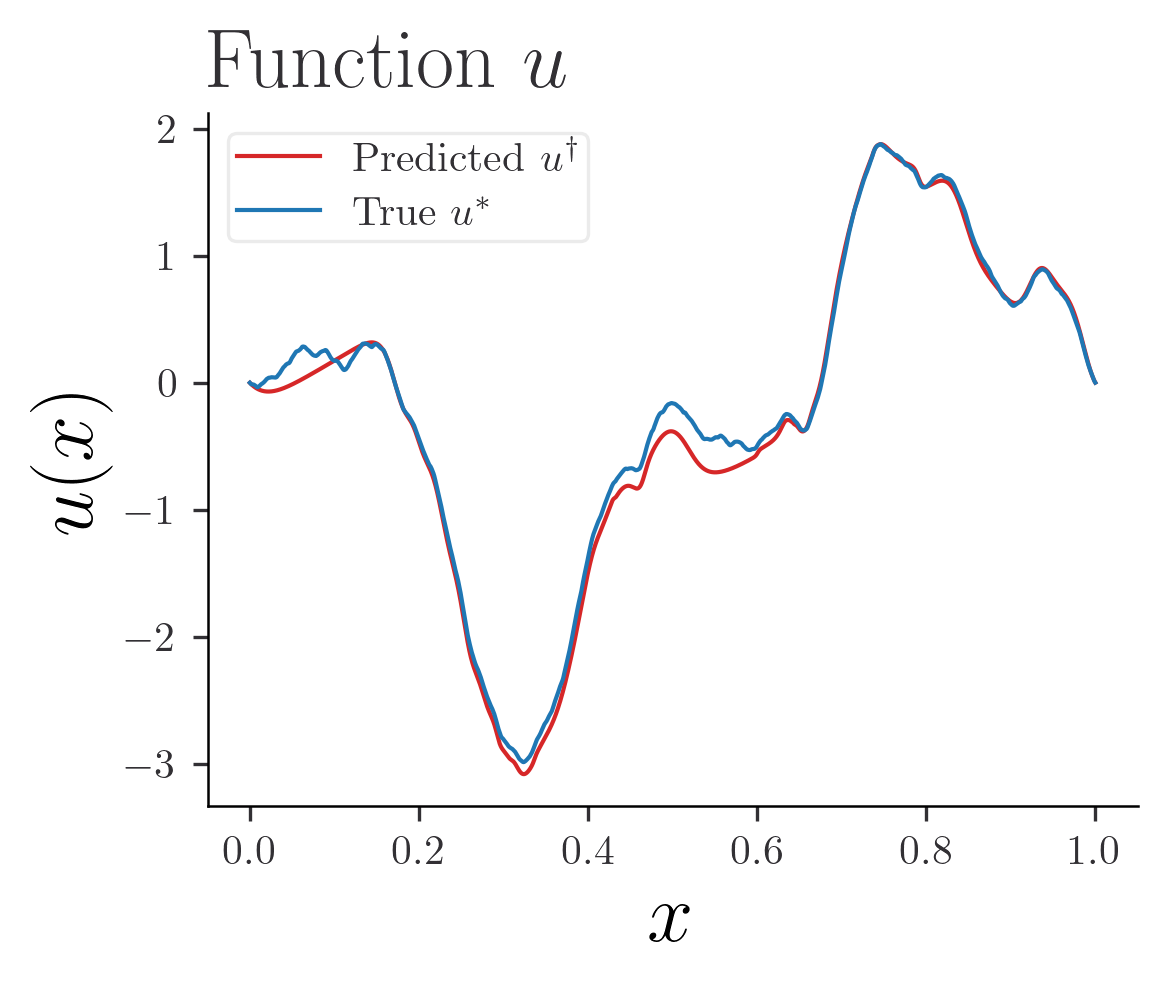

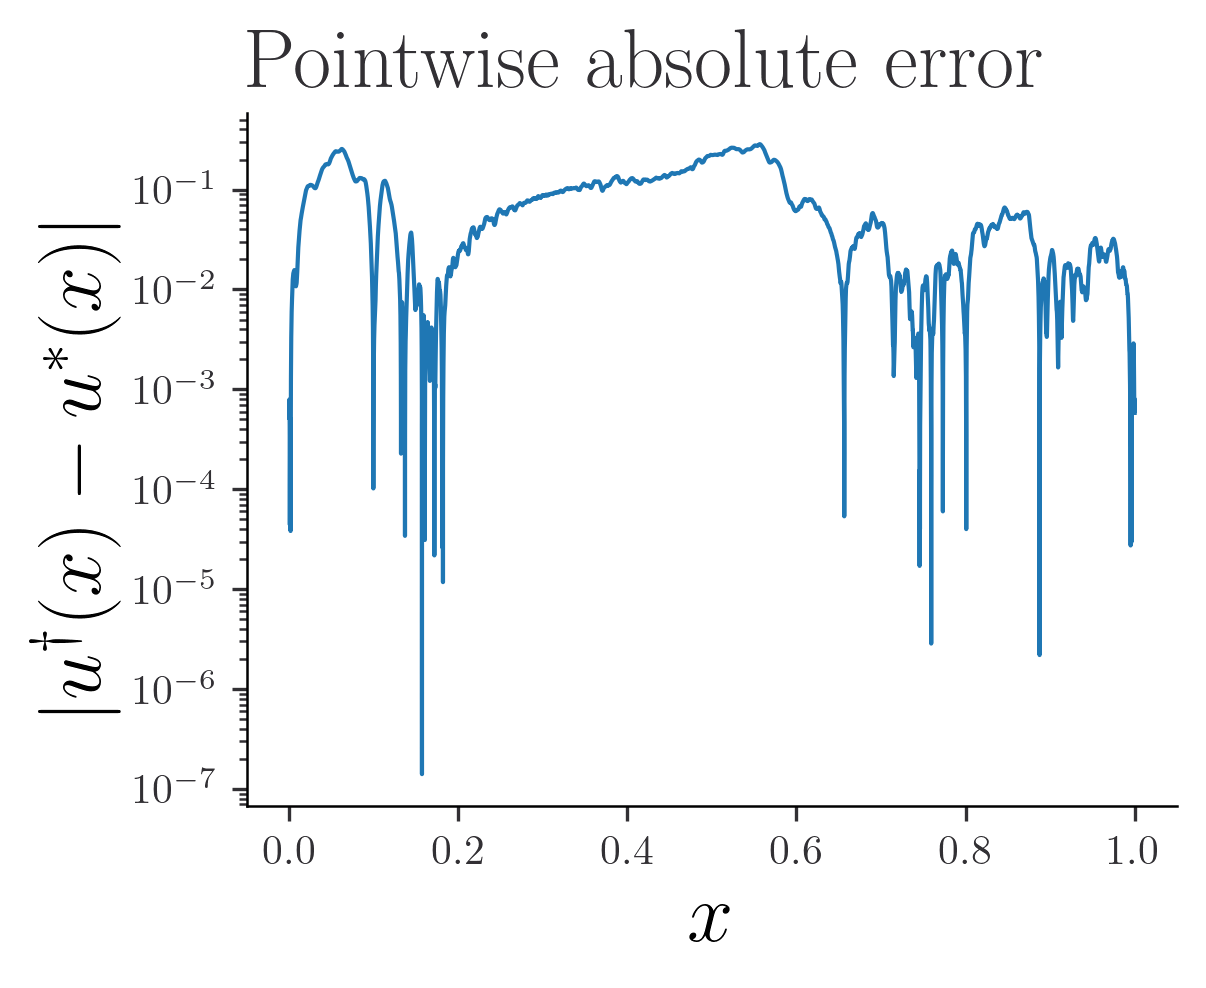

In [150]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


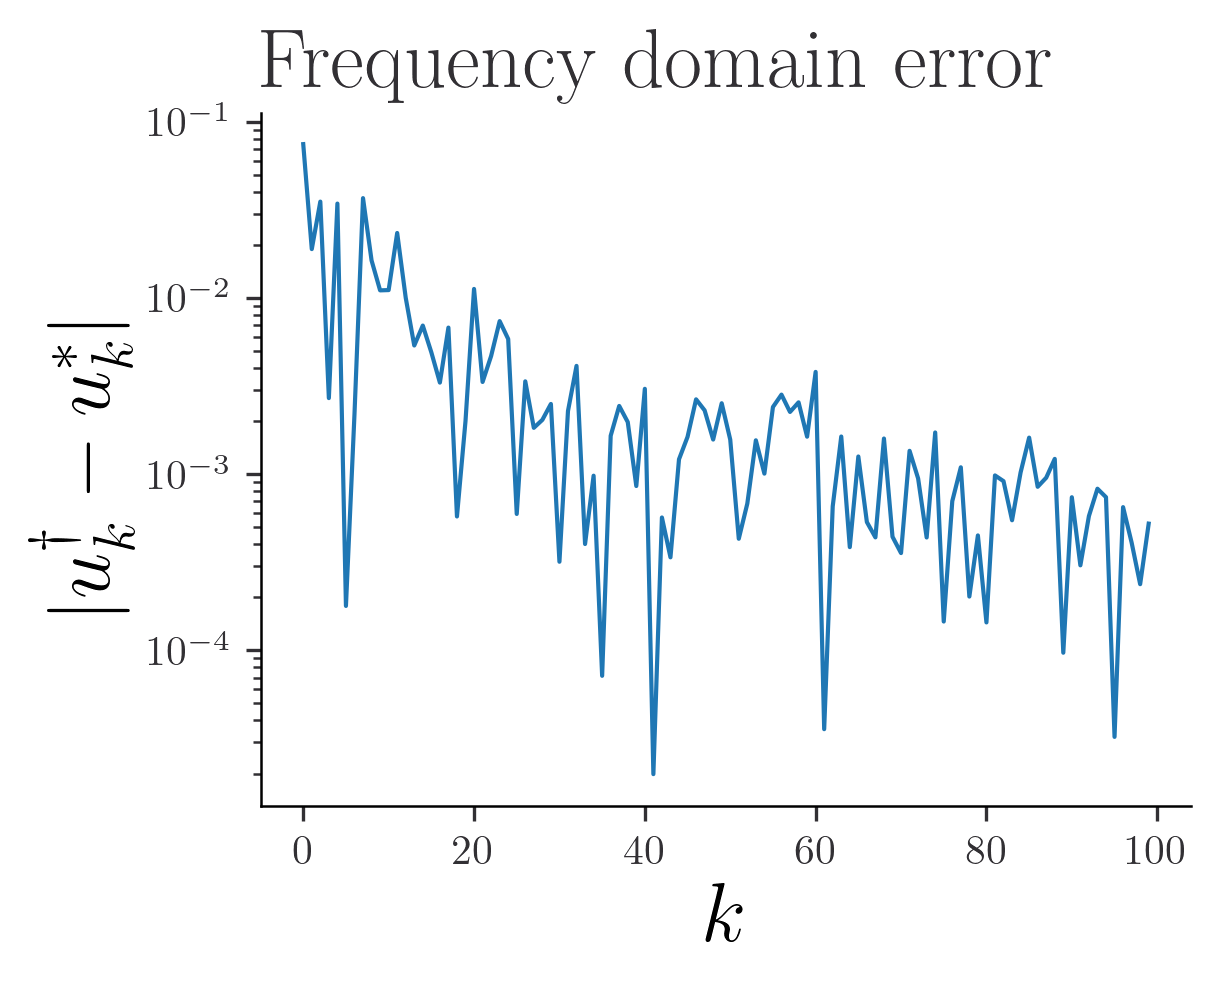

In [151]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

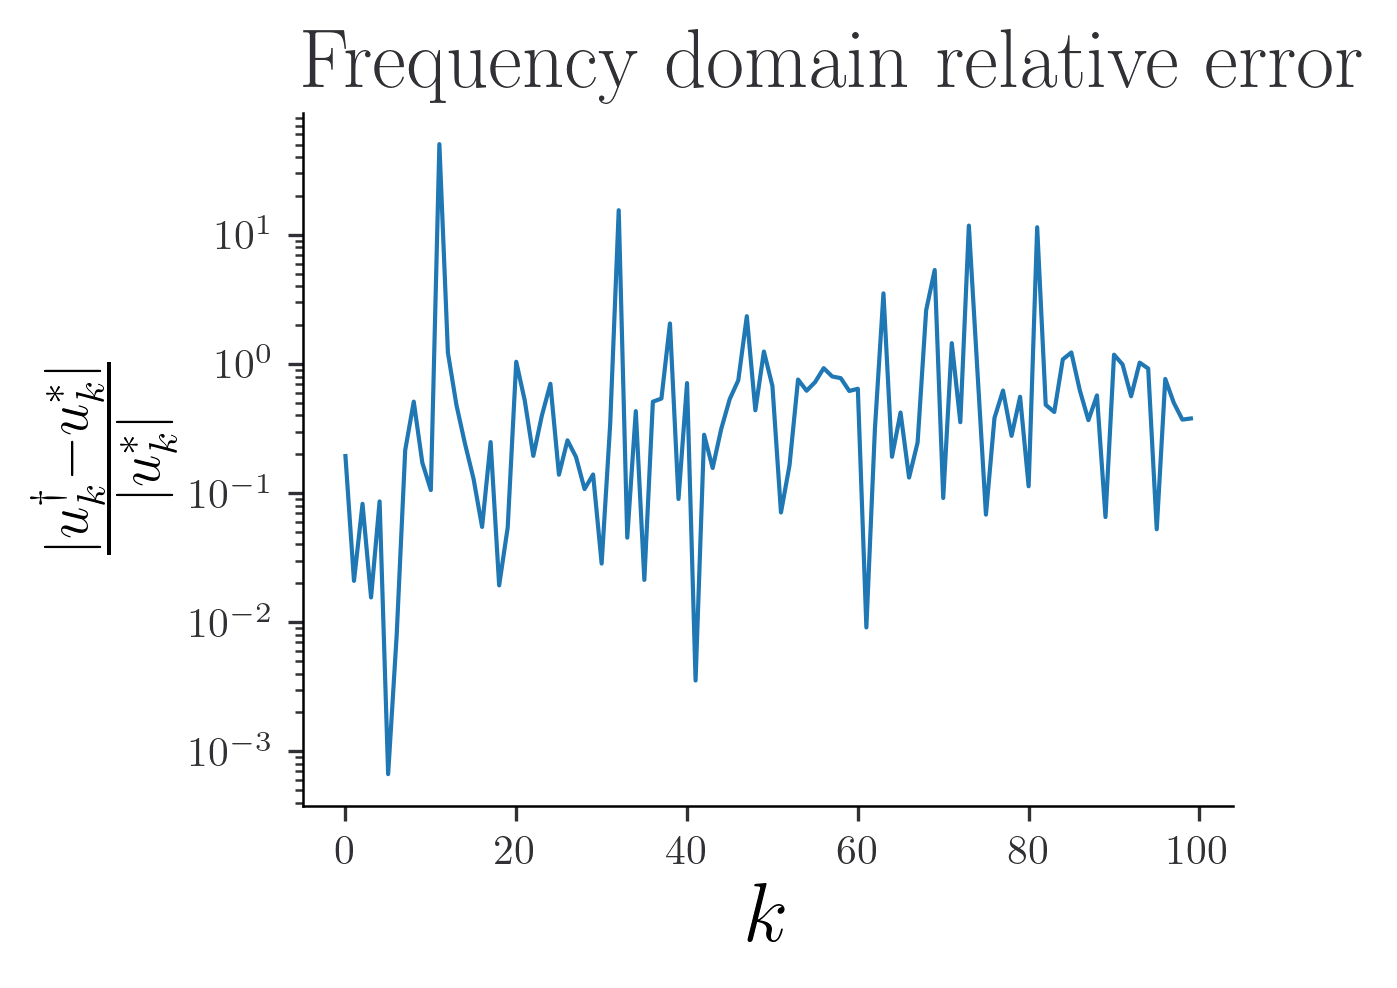

: 

In [152]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements + RFF ($H^{-1/2}$ norm)

In [90]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [91]:
t = 1/2
decay = jnp.arange(1, n_meas+1)**(-t/2)
decay

Array([1.        , 0.84089642, 0.75983569, ..., 0.12501526, 0.12500763,
       0.125     ], dtype=float64, weak_type=True)

In [92]:
# Draw random samples for the RF part
n_samples = 24
print('Number of samples: ', n_samples)
d_in = 1

key = random.PRNGKey(0)
key, subkey = random.split(key)
sigma_rff = 5.0
random_features = random.normal(subkey, shape = (n_samples, d_in))*sigma_rff

def feature_map(x, random_features):
    n_samples = random_features.shape[0]
    outputs = jnp.dot(random_features, x)
    return jnp.squeeze((1/jnp.sqrt(n_samples))*jnp.vstack([jnp.cos(outputs), jnp.sin(outputs)]))


def predict(params, x):
    activations = x
    # First pass through the feature map
    activations = feature_map(activations, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

Number of samples:  24


In [93]:
layer_sizes = [n_samples*2, 16, 16,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)*decay

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 1073 parameters in the neural network.


In [94]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [95]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
0.04205711732662491 [(Array([[-7.18006737e-04,  3.25900786e-03,  9.70327172e-04,
         3.83381296e-03,  1.84188961e-03, -1.26602690e-02,
        -3.31015924e-04, -6.56547820e-03,  5.54673774e-03,
         2.67038953e-03,  4.14980275e-03,  2.57632005e-05,
         4.31288543e-04, -1.50522056e-03, -3.73883423e-04,
        -2.33309726e-03],
       [-9.32568166e-03,  1.54891474e-03,  4.47538028e-03,
         8.33178305e-03,  8.47980787e-03, -3.67042251e-02,
        -4.38588272e-03, -2.05287871e-02,  2.57178932e-02,
         1.28366652e-02,  6.61438760e-03,  6.25427113e-03,
         1.33372731e-03, -9.22894710e-03, -5.03958050e-03,
        -1.18374571e-02],
       [-3.48693936e-03,  2.70802759e-03,  2.09976411e-03,
         5.28119851e-03,  3.97868899e-03, -2.03978714e-02,
        -1.63449701e-03, -1.10587672e-02,  1.20372718e-02,
         5.94239489e-03,  4.93953376e-03,  2.03155095e-03,
         7.21468015e-04, -3.99119500e-03, -1.87481604e-03,
        -5.39348587

In [96]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [97]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [98]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 0.0420571
Step 0, Training Loss: 0.0420571, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0272652
Step 10000, Training Loss: 0.0272652, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0262452
Step 20000, Training Loss: 0.0262452, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0258151
Step 30000, Training Loss: 0.0258151, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0252994
Step 40000, Training Loss: 0.0252994, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0252056
Step 50000, Training Loss: 0.0252056, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0250738
Step 60000, Training Loss: 0.0250738, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0249768
Step 70000, Training Loss: 0.0249768, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0248770
Step 80000, Training Loss: 0.0248770, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0248287
Step 90000, Training Loss: 0.0248287, Learning Rate: 0.000387


In [99]:
pred = neural_network(params, domain_finest)

In [100]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

0.01593342769338286 0.01280325565046776


In [101]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(0.01593342, dtype=float64), Array(0.01280325, dtype=float64))

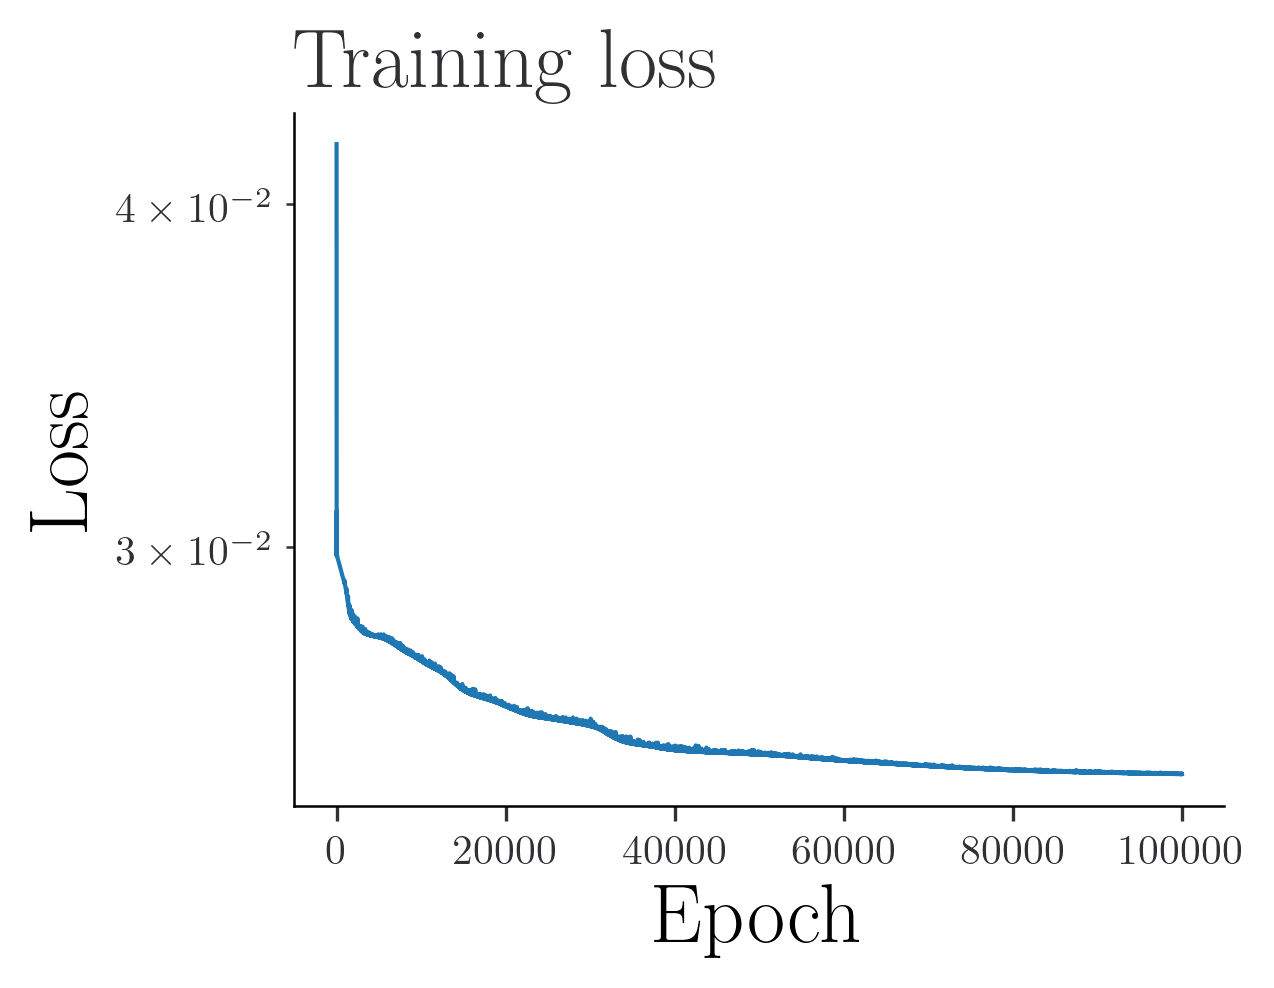

In [102]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

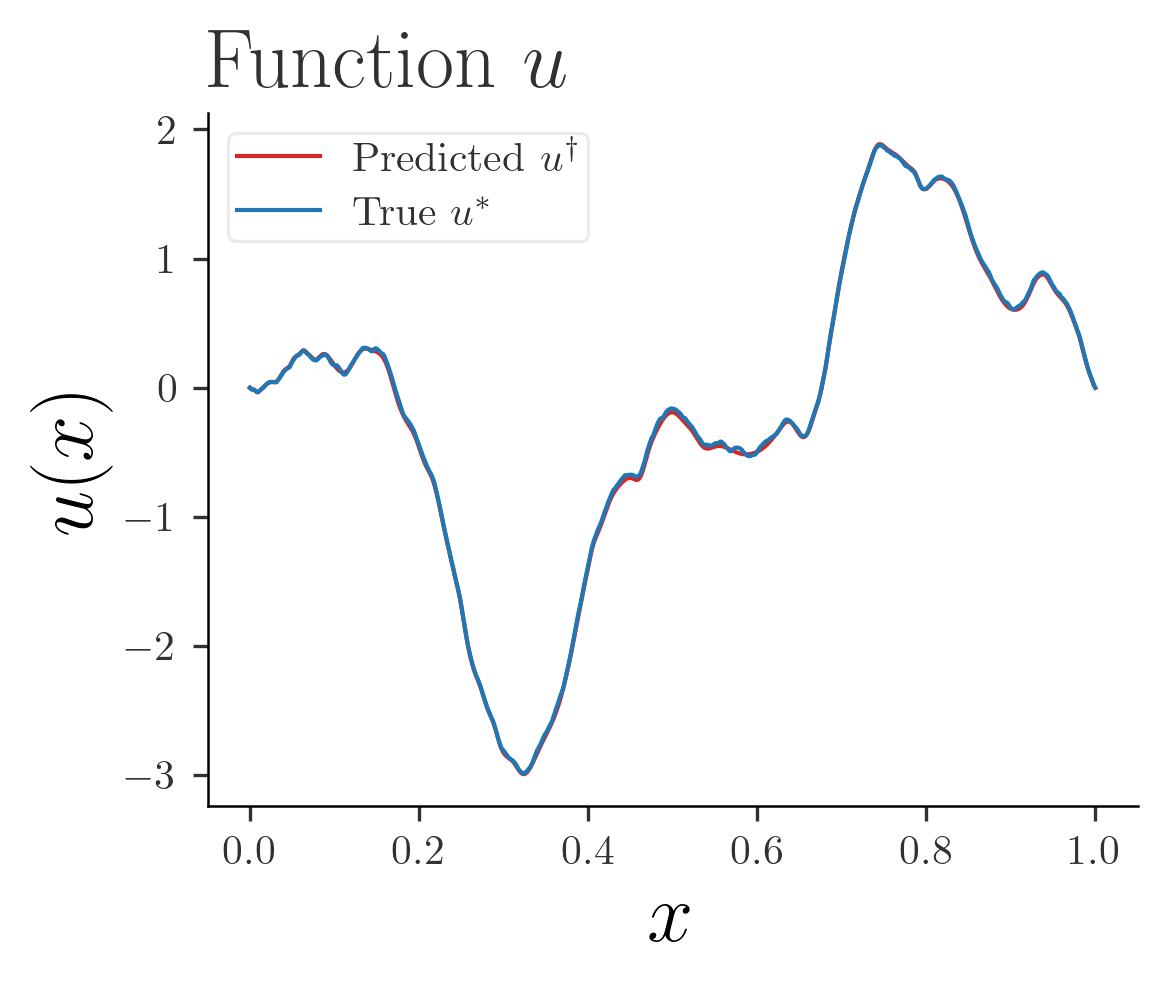

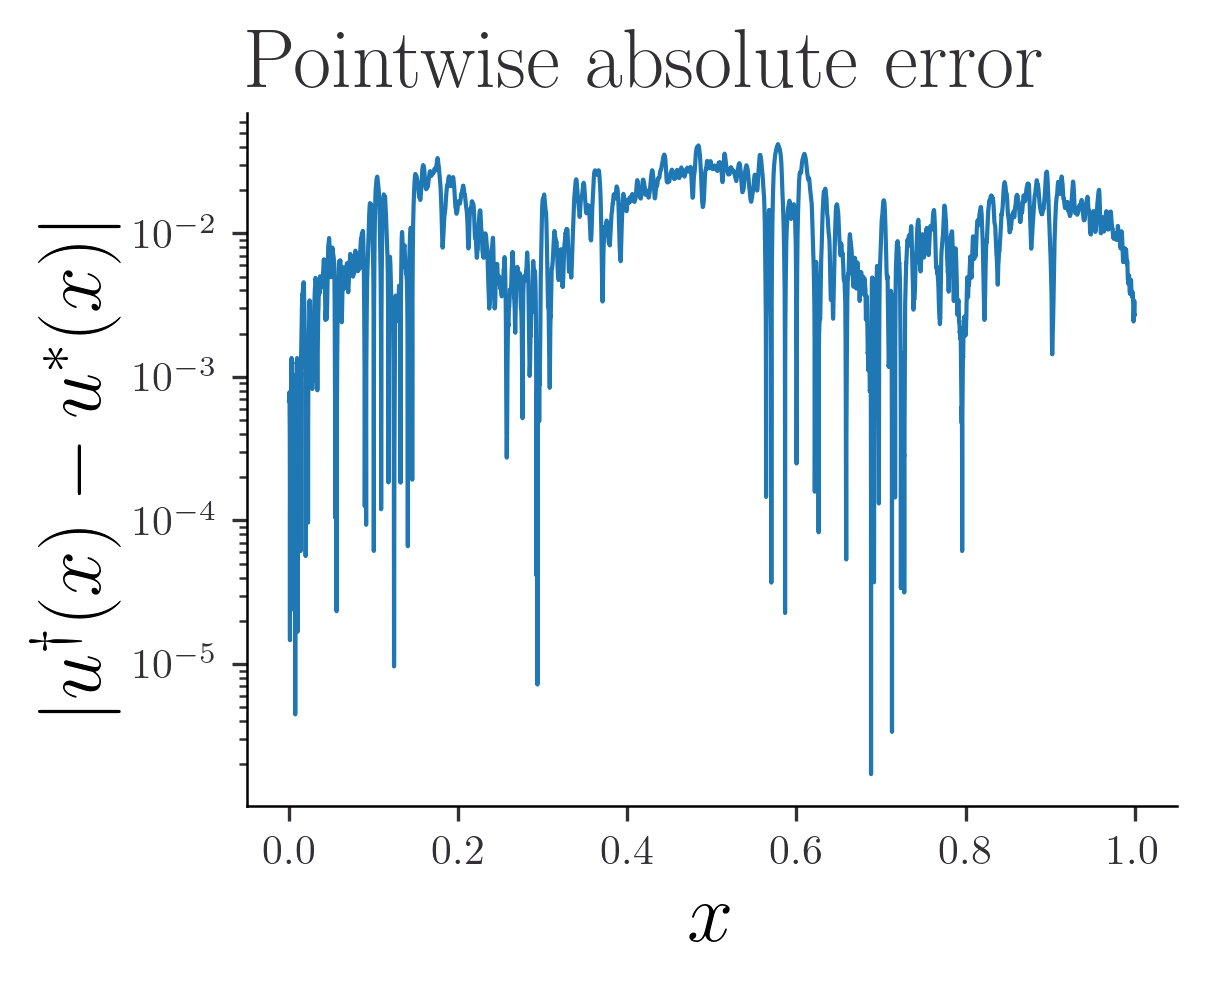

In [103]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


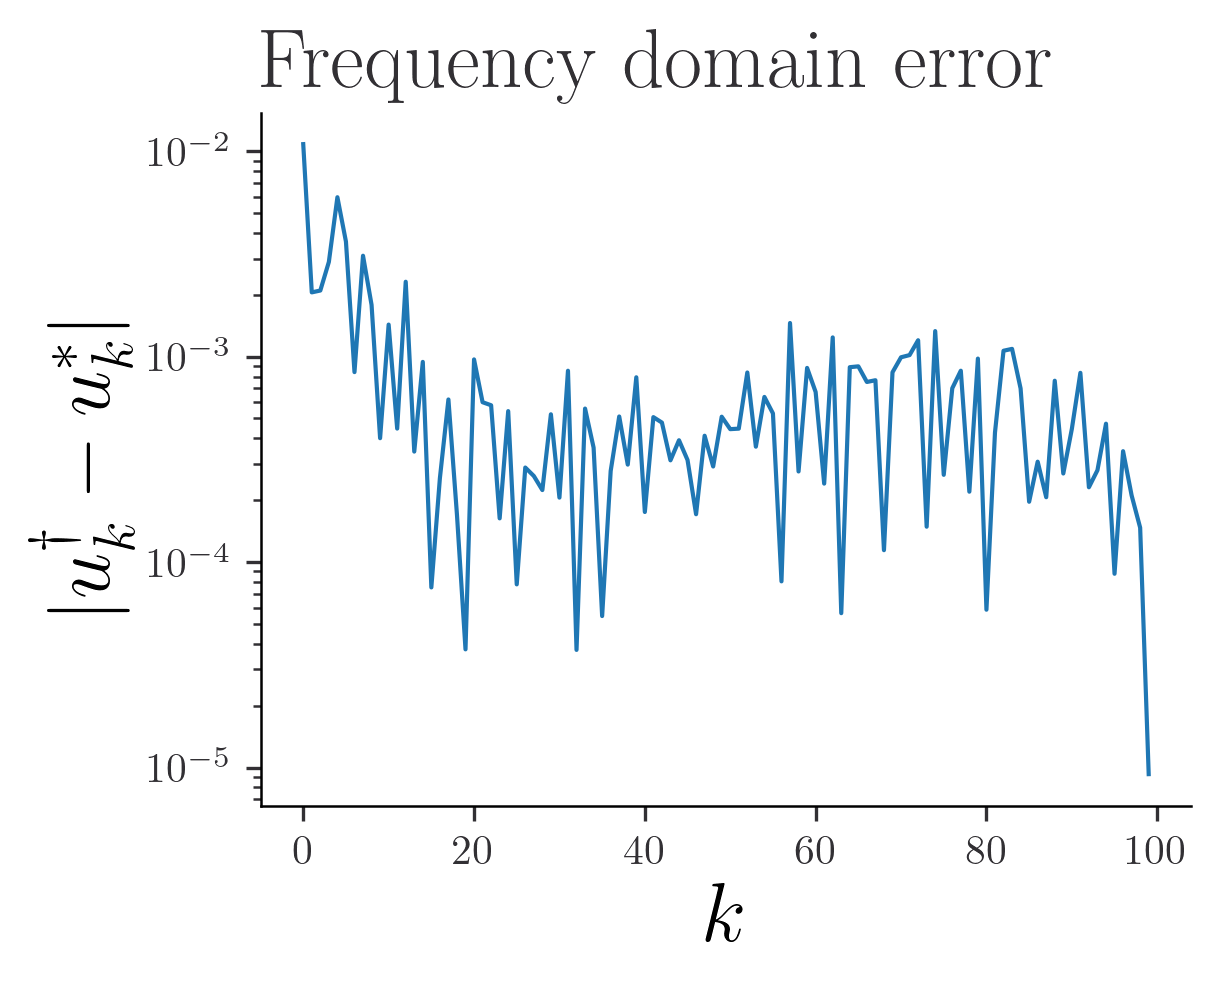

In [104]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

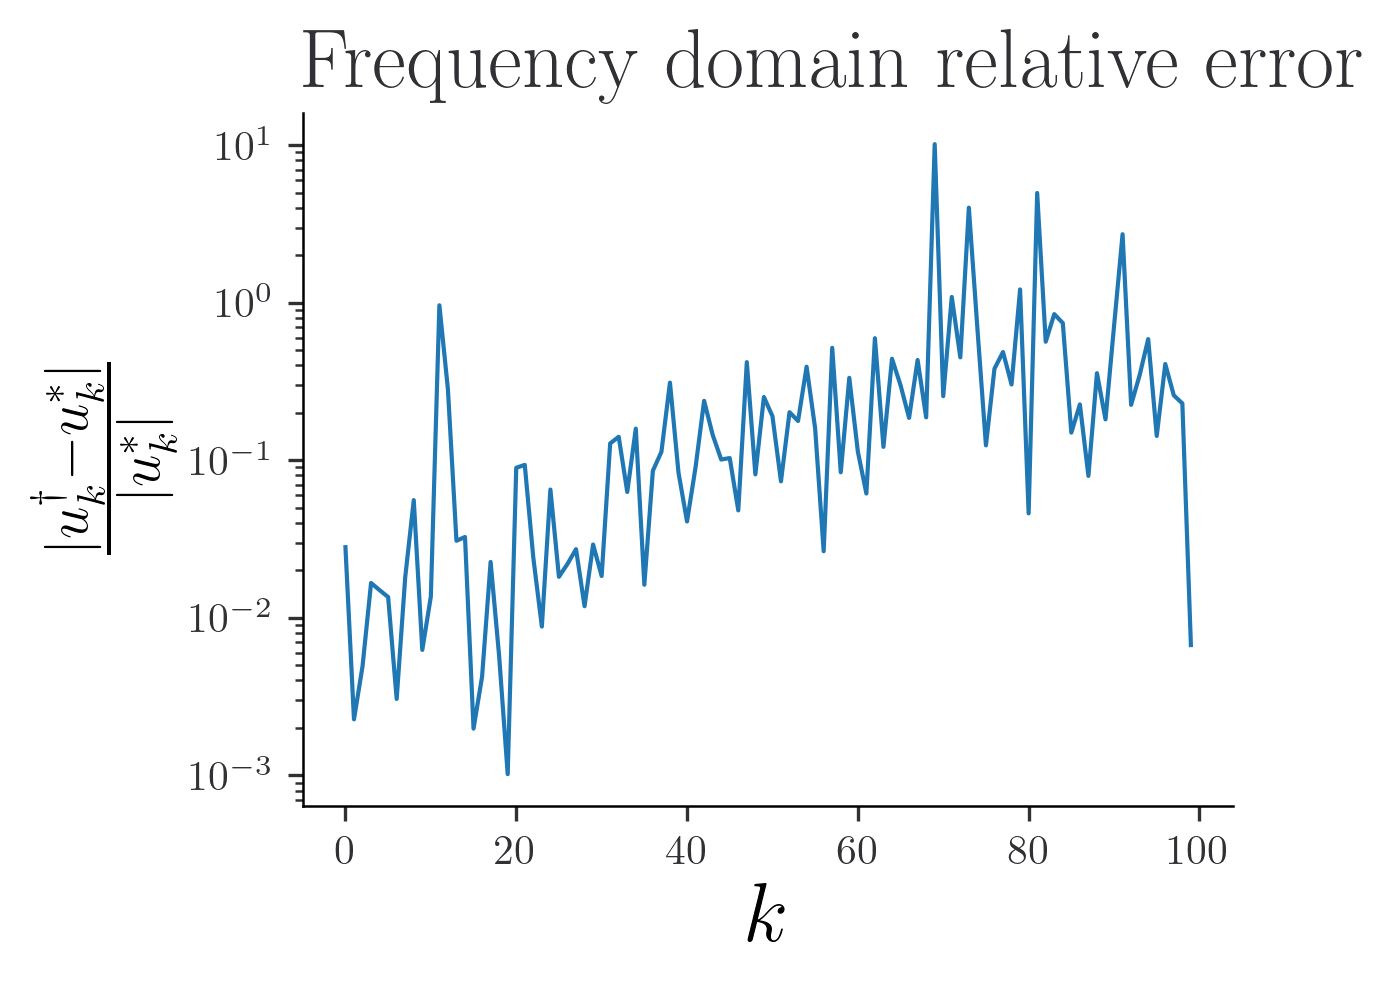

In [105]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements + RFF ($H^{-3/4}$ norm)

In [106]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [107]:
t = 3/4
decay = jnp.arange(1, n_meas+1)**(-t/2)
decay

Array([1.        , 0.77110541, 0.66233778, ..., 0.04420227, 0.04419822,
       0.04419417], dtype=float64, weak_type=True)

In [108]:
# Draw random samples for the RF part
n_samples = 24
print('Number of samples: ', n_samples)
d_in = 1

key = random.PRNGKey(0)
key, subkey = random.split(key)
sigma_rff = 5.0
random_features = random.normal(subkey, shape = (n_samples, d_in))*sigma_rff

def feature_map(x, random_features):
    n_samples = random_features.shape[0]
    outputs = jnp.dot(random_features, x)
    return jnp.squeeze((1/jnp.sqrt(n_samples))*jnp.vstack([jnp.cos(outputs), jnp.sin(outputs)]))


def predict(params, x):
    activations = x
    # First pass through the feature map
    activations = feature_map(activations, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

Number of samples:  24


In [109]:
layer_sizes = [n_samples*2, 16, 16,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)*decay

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 1073 parameters in the neural network.


In [110]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [111]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
0.018949233292798268 [(Array([[-7.14991131e-04,  3.25909004e-03,  9.68560490e-04,
         3.83210616e-03,  1.83903507e-03, -1.26491249e-02,
        -3.30428190e-04, -6.56001118e-03,  5.53899196e-03,
         2.66594474e-03,  4.14902602e-03,  2.30674493e-05,
         4.31072895e-04, -1.50187557e-03, -3.71880985e-04,
        -2.32832308e-03],
       [-9.32519521e-03,  1.54795328e-03,  4.47625175e-03,
         8.33180036e-03,  8.48108689e-03, -3.67063606e-02,
        -4.38461149e-03, -2.05296001e-02,  2.57198291e-02,
         1.28371638e-02,  6.61054837e-03,  6.25556956e-03,
         1.33245246e-03, -9.23031833e-03, -5.03926722e-03,
        -1.18398578e-02],
       [-3.48376204e-03,  2.70798142e-03,  2.09773089e-03,
         5.27957489e-03,  3.97607470e-03, -2.03879530e-02,
        -1.63401691e-03, -1.10536727e-02,  1.20306477e-02,
         5.93824244e-03,  4.93832341e-03,  2.02902014e-03,
         7.21025497e-04, -3.98837970e-03, -1.87278678e-03,
        -5.3891946

In [112]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [113]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [114]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 0.0189492
Step 0, Training Loss: 0.0189492, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0052766
Step 10000, Training Loss: 0.0052766, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0050376
Step 20000, Training Loss: 0.0050376, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0049638
Step 30000, Training Loss: 0.0049638, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0049003
Step 40000, Training Loss: 0.0049003, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0047277
Step 50000, Training Loss: 0.0047277, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0046254
Step 60000, Training Loss: 0.0046254, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0045550
Step 70000, Training Loss: 0.0045550, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0045318
Step 80000, Training Loss: 0.0045318, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0044924
Step 90000, Training Loss: 0.0044924, Learning Rate: 0.000387


In [115]:
pred = neural_network(params, domain_finest)

In [116]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

0.03208685886327239 0.025783294401716547


In [117]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(0.03208686, dtype=float64), Array(0.02578329, dtype=float64))

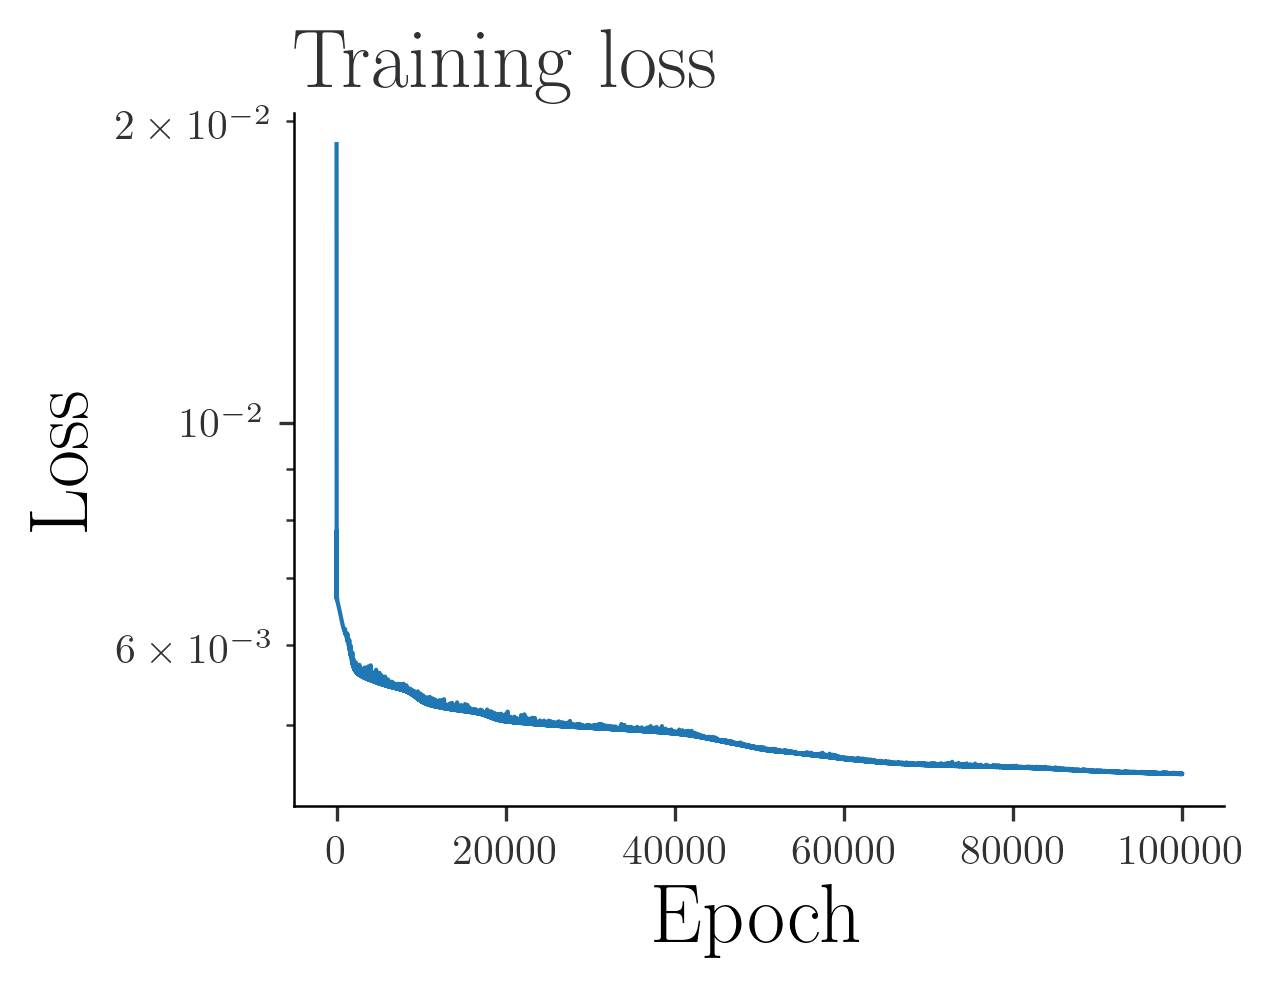

In [118]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

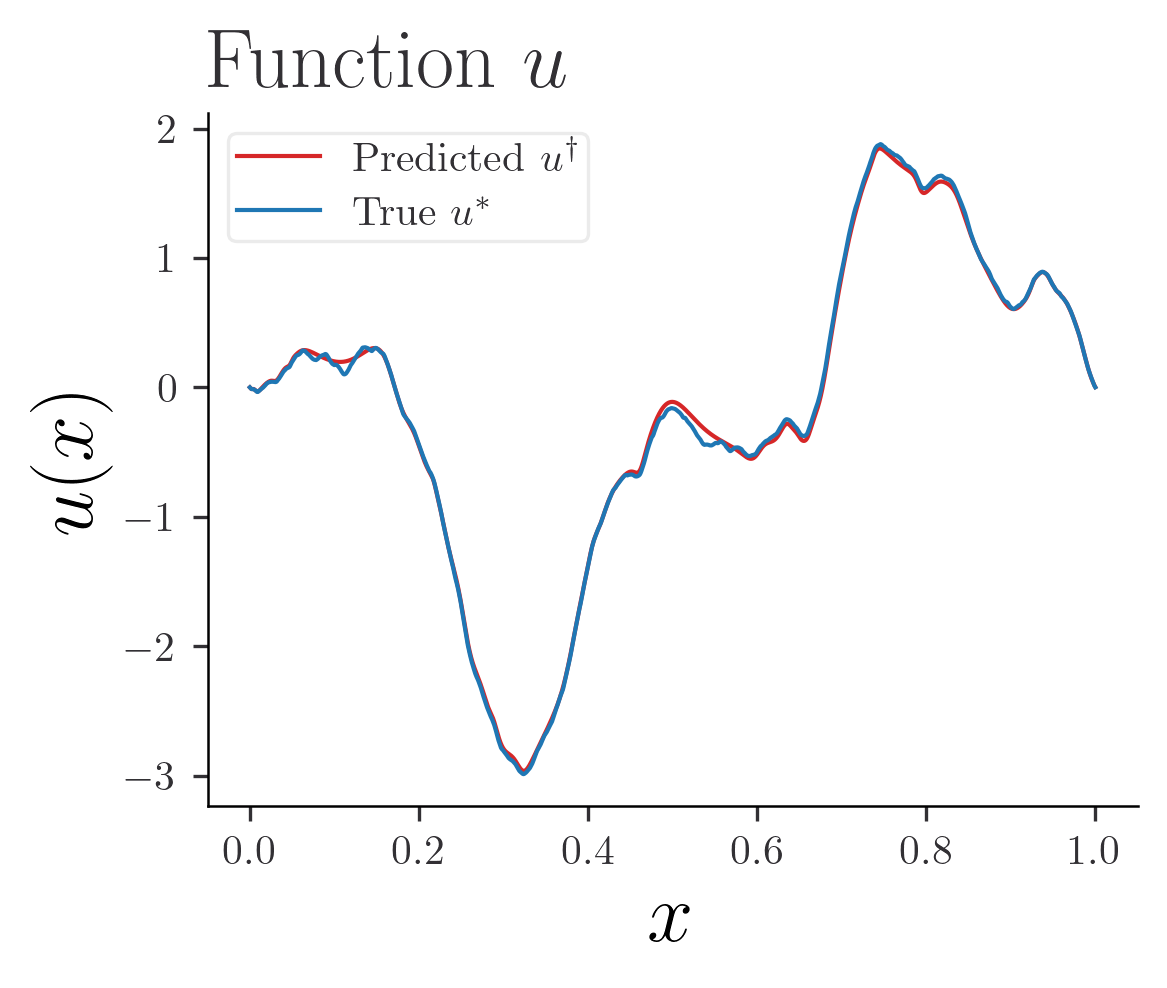

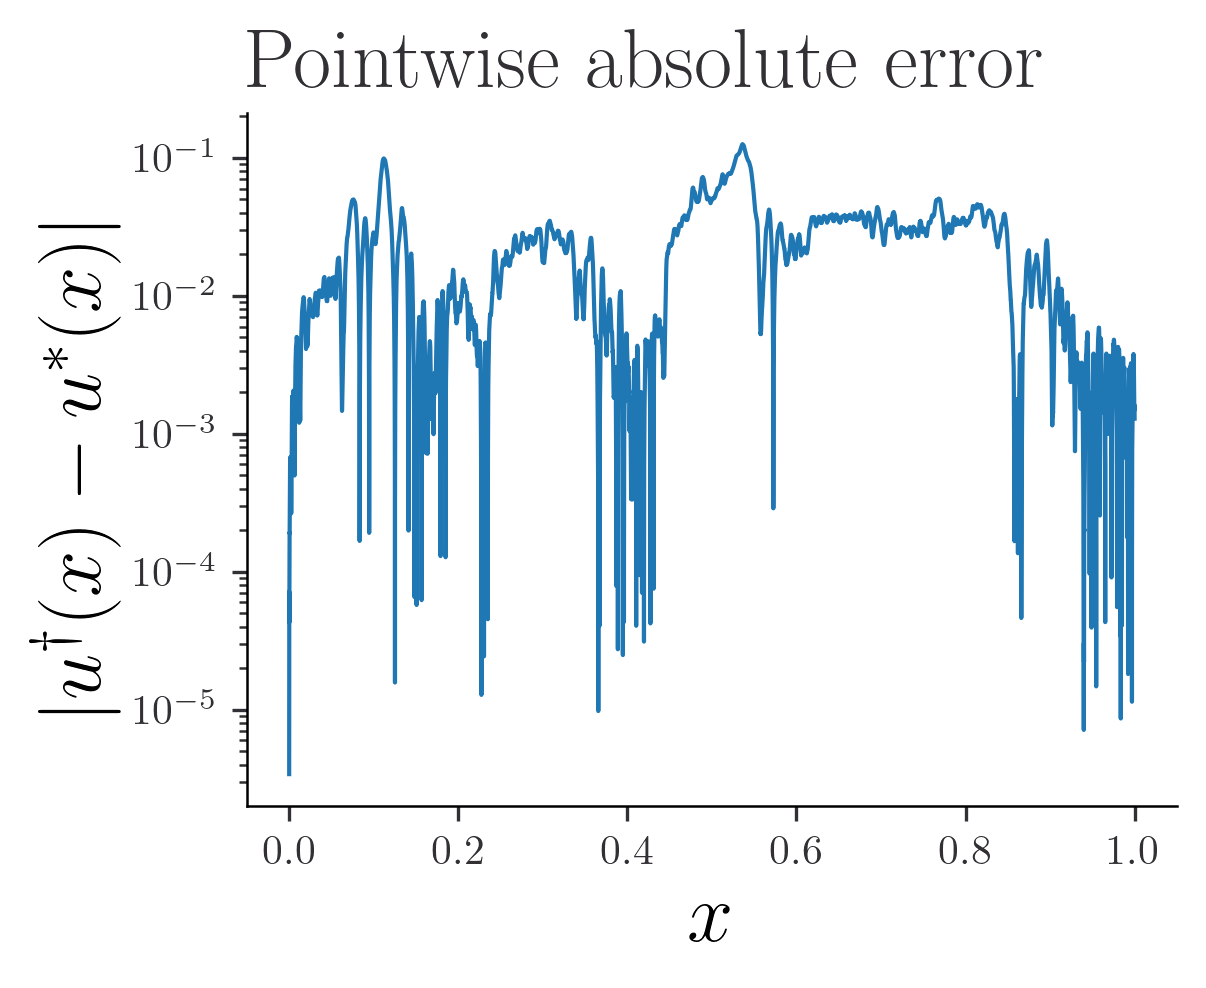

In [119]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


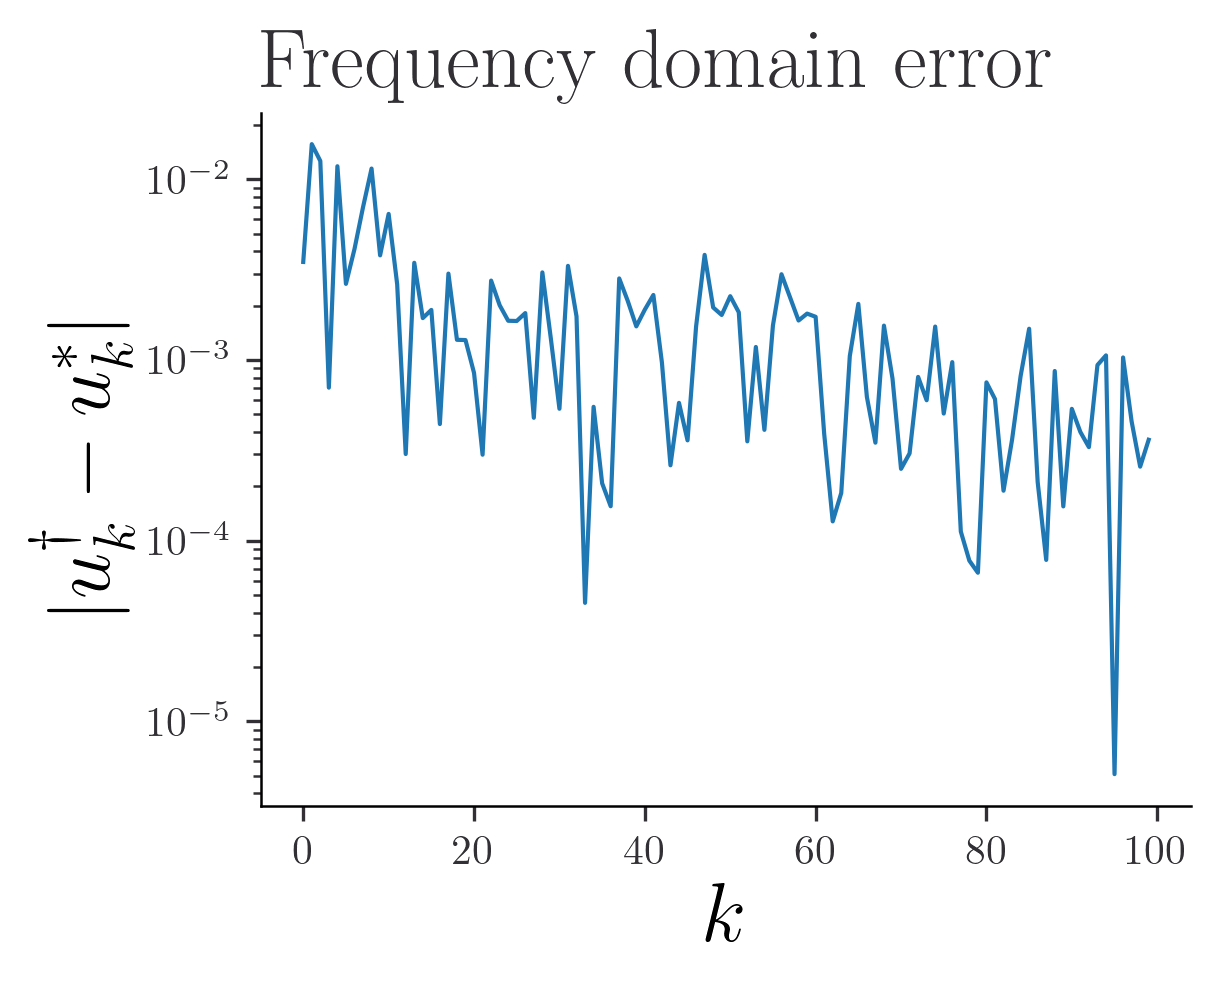

In [120]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

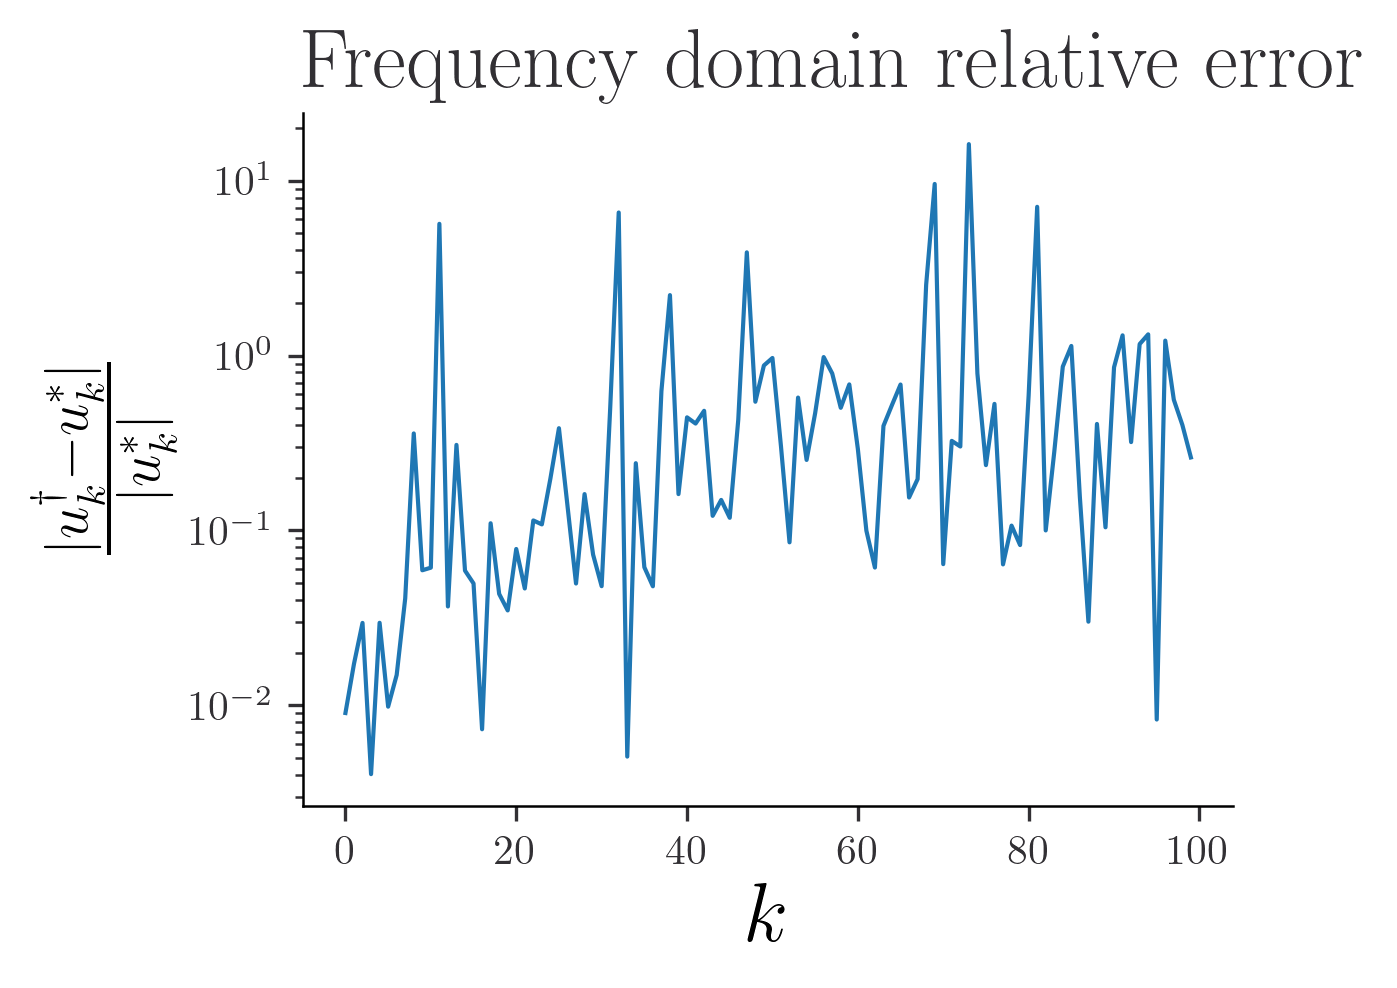

In [121]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements + RFF ($H^{-1}$ norm)

In [122]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [123]:
t = 1.0
decay = jnp.arange(1, n_meas+1)**(-t/2)
decay

Array([1.        , 0.70710678, 0.57735027, ..., 0.01562882, 0.01562691,
       0.015625  ], dtype=float64, weak_type=True)

In [124]:
# Draw random samples for the RF part
n_samples = 24
print('Number of samples: ', n_samples)
d_in = 1

key = random.PRNGKey(0)
key, subkey = random.split(key)
sigma_rff = 5.0
random_features = random.normal(subkey, shape = (n_samples, d_in))*sigma_rff

def feature_map(x, random_features):
    n_samples = random_features.shape[0]
    outputs = jnp.dot(random_features, x)
    return jnp.squeeze((1/jnp.sqrt(n_samples))*jnp.vstack([jnp.cos(outputs), jnp.sin(outputs)]))


def predict(params, x):
    activations = x
    # First pass through the feature map
    activations = feature_map(activations, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

Number of samples:  24


In [125]:
layer_sizes = [n_samples*2, 16, 16,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)*decay

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 1073 parameters in the neural network.


In [126]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [127]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
0.014334474706702497 [(Array([[-7.12421162e-04,  3.25921984e-03,  9.67195829e-04,
         3.83066543e-03,  1.83668152e-03, -1.26400327e-02,
        -3.29837591e-04, -6.55543893e-03,  5.53251203e-03,
         2.66234402e-03,  4.14835215e-03,  2.09186180e-05,
         4.30918393e-04, -1.49905943e-03, -3.70260945e-04,
        -2.32455918e-03],
       [-9.32492104e-03,  1.54741495e-03,  4.47684599e-03,
         8.33198318e-03,  8.48195454e-03, -3.67082650e-02,
        -4.38389941e-03, -2.05303482e-02,  2.57213748e-02,
         1.28375699e-02,  6.60810443e-03,  6.25642986e-03,
         1.33166122e-03, -9.23129954e-03, -5.03910788e-03,
        -1.18415120e-02],
       [-3.48112518e-03,  2.70803013e-03,  2.09623123e-03,
         5.27822524e-03,  3.97391451e-03, -2.03798001e-02,
        -1.63350349e-03, -1.10494201e-02,  1.20249862e-02,
         5.93488159e-03,  4.93736034e-03,  2.02701602e-03,
         7.20729742e-04, -3.98594780e-03, -1.87116835e-03,
        -5.3857995

In [128]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [129]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [130]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 0.0143345
Step 0, Training Loss: 0.0143345, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0012347
Step 10000, Training Loss: 0.0012347, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0011644
Step 20000, Training Loss: 0.0011644, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0011284
Step 30000, Training Loss: 0.0011284, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0010986
Step 40000, Training Loss: 0.0010986, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0010661
Step 50000, Training Loss: 0.0010661, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0010319
Step 60000, Training Loss: 0.0010319, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0010129
Step 70000, Training Loss: 0.0010129, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0009771
Step 80000, Training Loss: 0.0009771, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0009393
Step 90000, Training Loss: 0.0009393, Learning Rate: 0.000387


In [131]:
pred = neural_network(params, domain_finest)

In [132]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

0.02488545164419465 0.019996626307238197


In [133]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(0.02488545, dtype=float64), Array(0.01999663, dtype=float64))

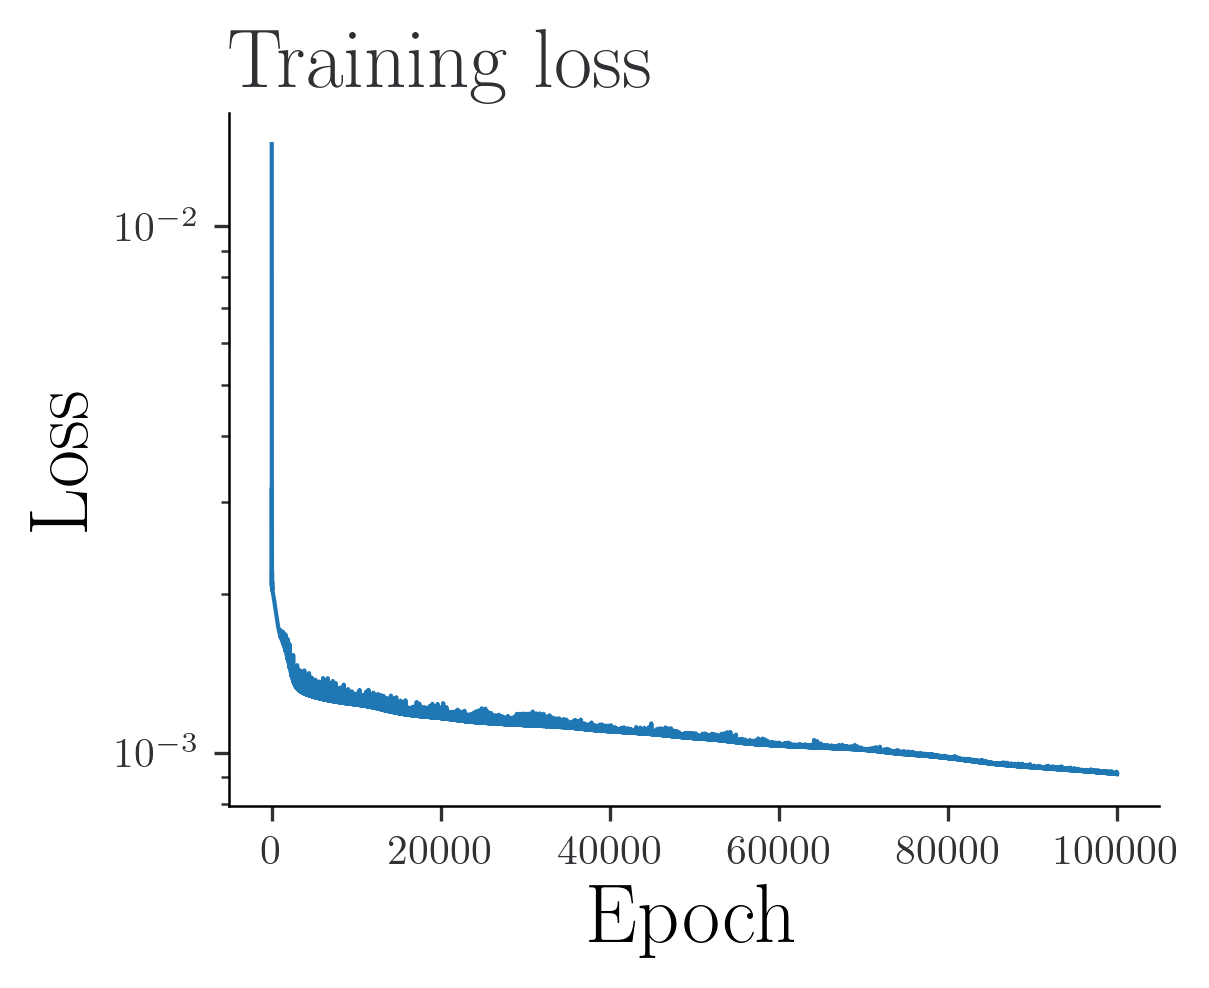

In [134]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

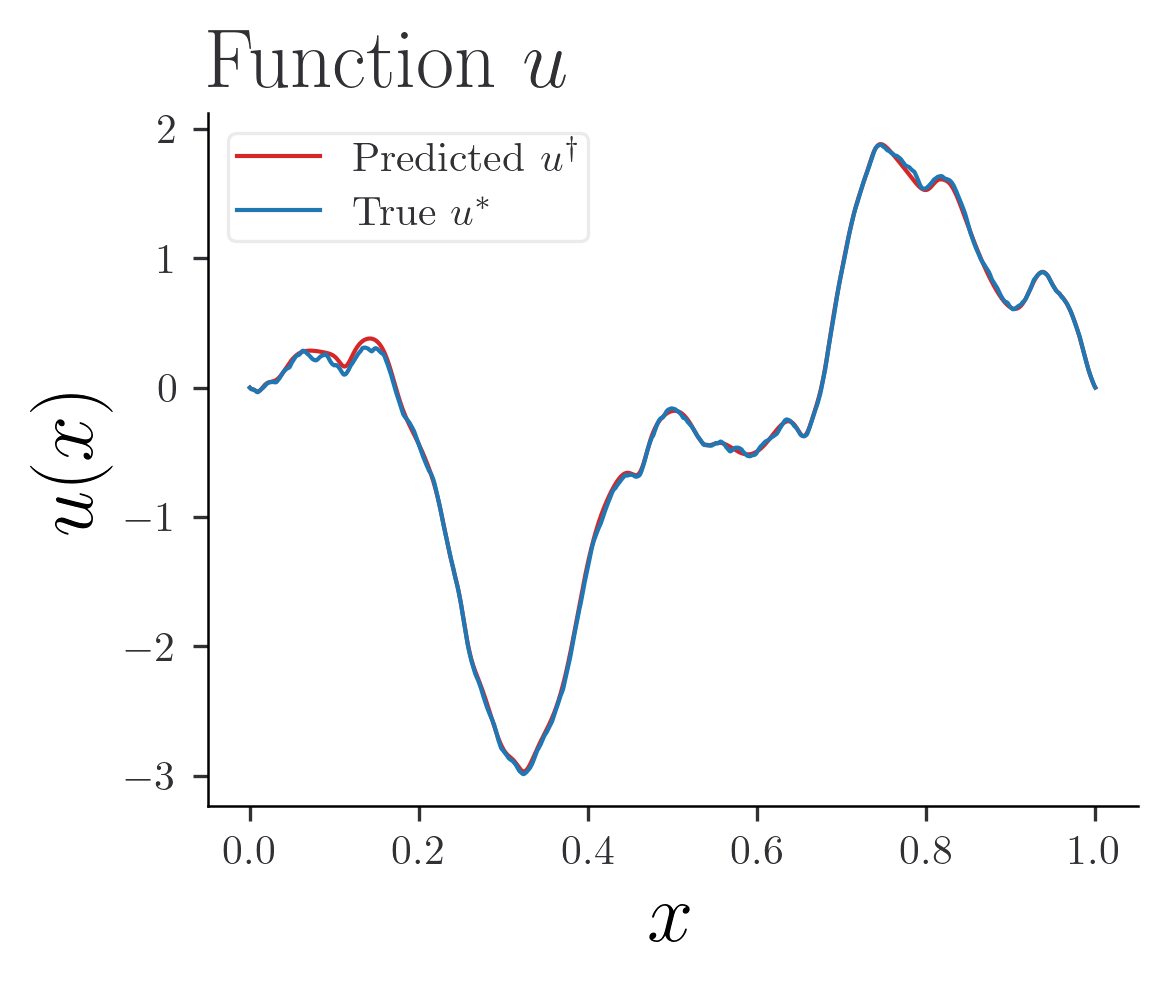

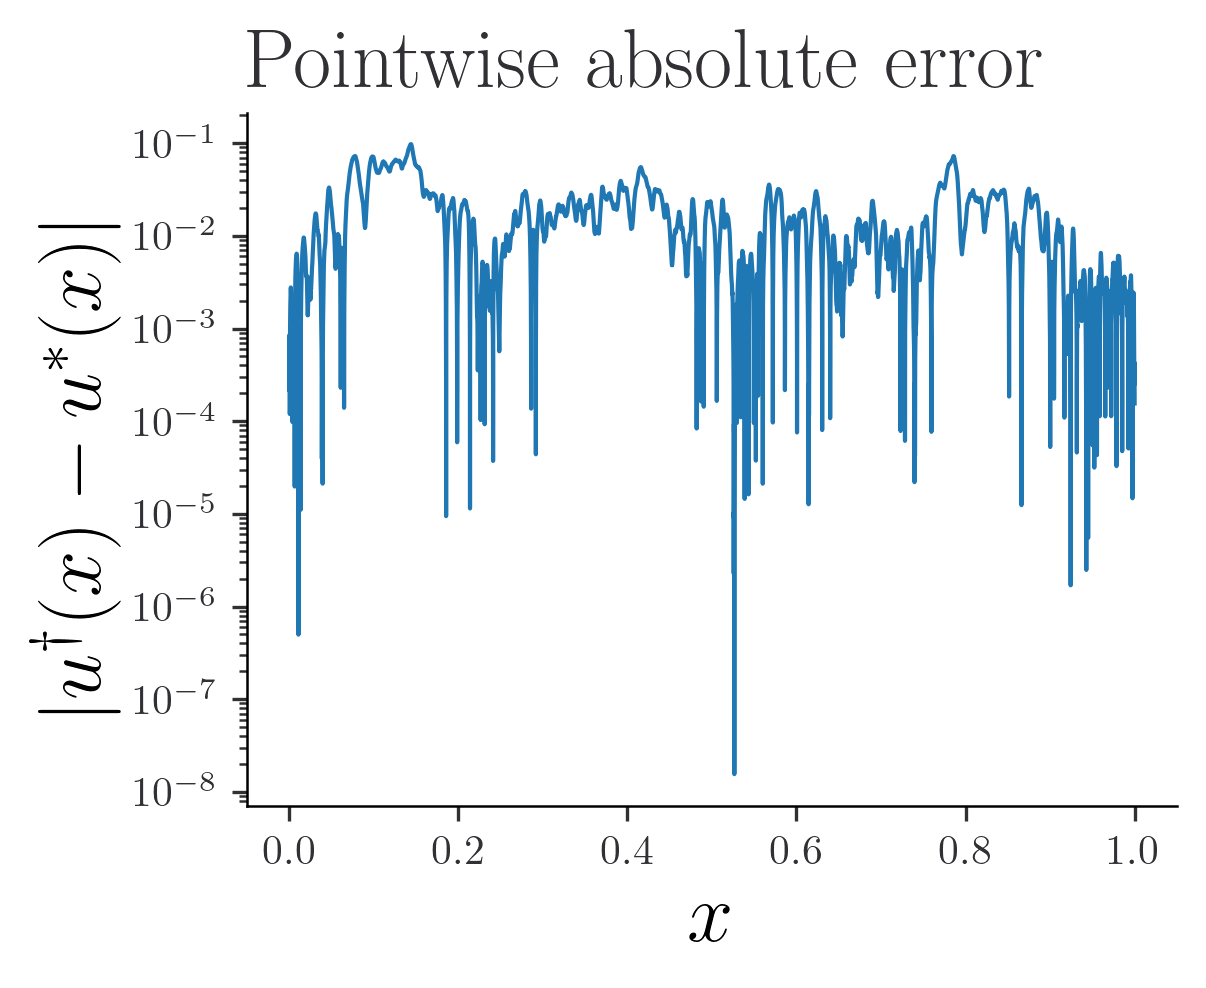

In [135]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


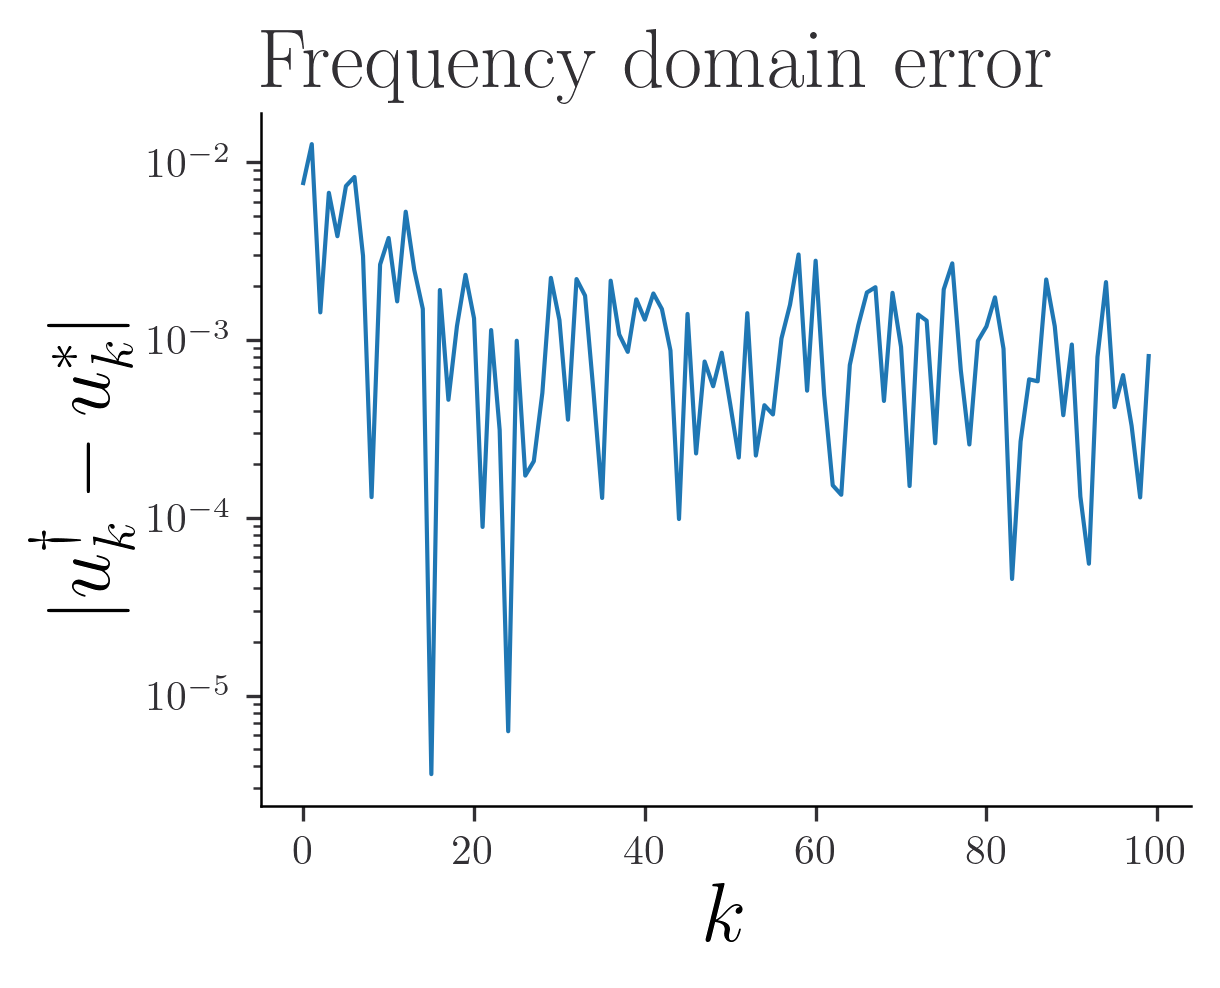

In [136]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

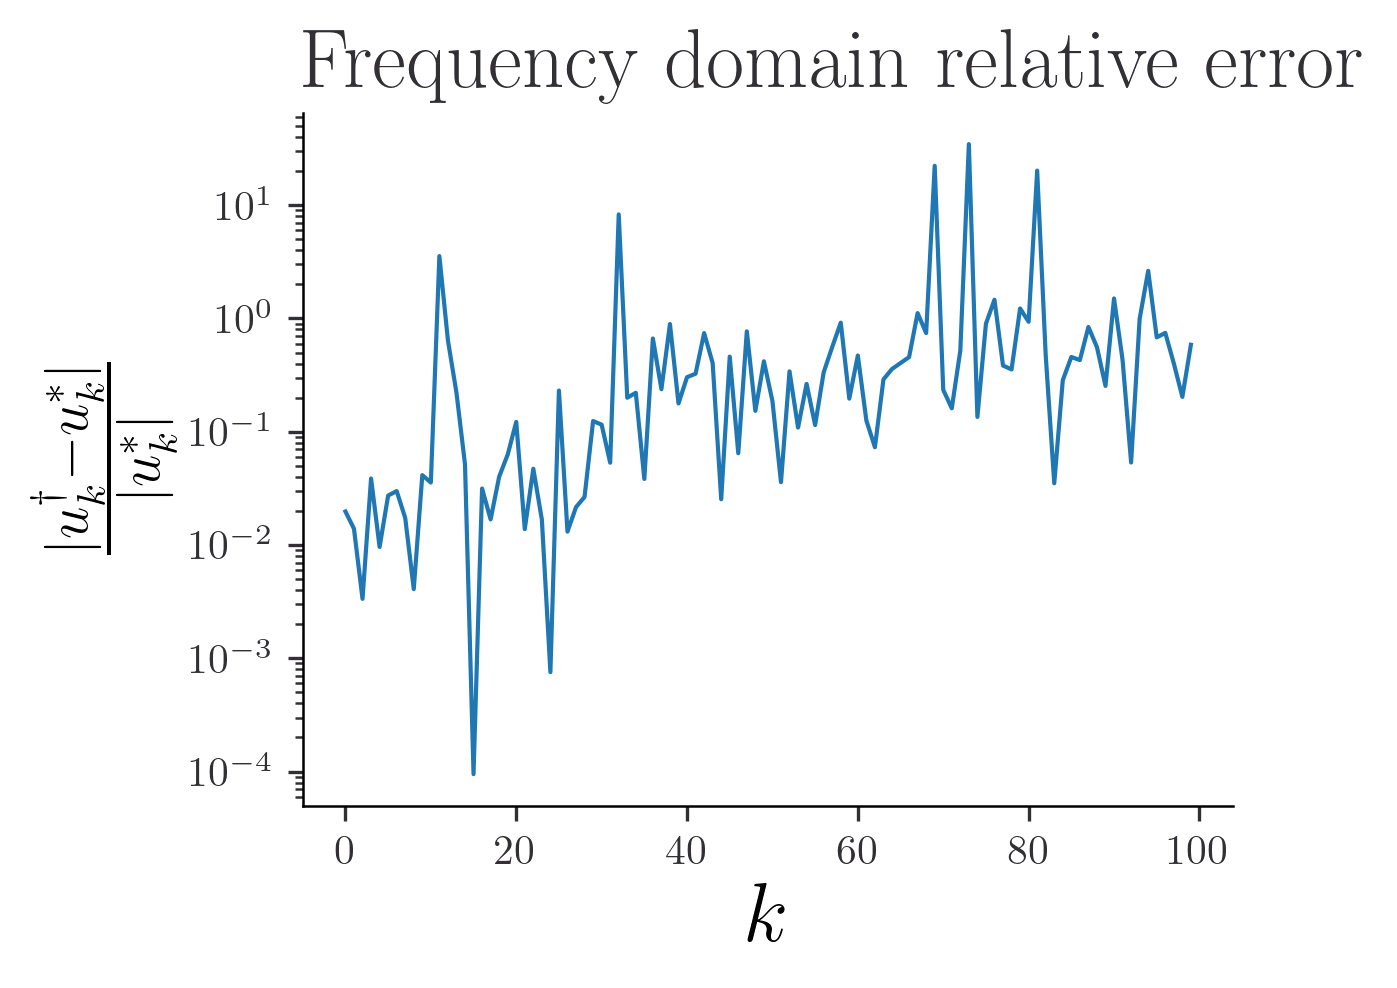

In [137]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()